<a href="https://colab.research.google.com/github/yongjulee0213/SentenceClassifier/blob/main/albert_base_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0️⃣ Prerequisite

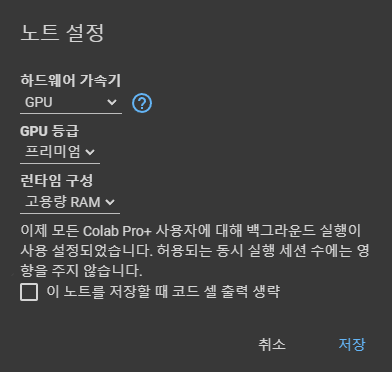

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.0 MB/s 
     |████████████████████████████████| 182 kB 98.7 MB/s 
     |████████████████████████████████| 7.6 MB 82.9 MB/s 


In [2]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 2.1 MB/s 


## Intall wnadb library and login

In [3]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.0 MB/s 
     |████████████████████████████████| 182 kB 92.5 MB/s 
     |████████████████████████████████| 174 kB 97.6 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 173 kB 91.7 MB/s 
     |████████████████████████████████| 168 kB 89.0 MB/s 
     |████████████████████████████████| 168 kB 97.1 MB/s 
     |████████████████████████████████| 166 kB 97.3 MB/s 
     |████████████████████████████████| 166 kB 95.5 MB/s 
     |████████████████████████████████| 162 kB 93.9 MB/s 
     |████████████████████████████████| 162 kB 96.0 MB/s 
     |████████████████████████████████| 158 kB 78.7 MB/s 
     |████████████████████████████████| 157 kB 88.1 MB/s 
     |████████████████████████████████| 157 kB 88.0 MB/s 
     |████████████████████████████████| 157 kB 91.2 MB/s 
     |████████████████████████████

In [4]:
# Log in to your W&B account
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## ✅ Choose a Pretrained Language Model to Use

- [BERT](https://huggingface.co/docs/transformers/model_doc/bert)
    - [transformers.BertTokenize](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer)
    - [transformers.BertForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForSequenceClassification)

- [ALBERT](https://huggingface.co/docs/transformers/model_doc/albert)
    - [transformers.AlbertTokenizer](https://huggingface.co/docs/transformers/model_doc/albert#transformers.AlbertTokenizer)
    - [transformers.AlbertForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/albert#transformers.AlbertForSequenceClassification)

In [5]:
#MY_MODEL_NAME = 'bert-base'
#MY_MODEL_NAME = 'bert-large'
MY_MODEL_NAME = 'albert-base'
#MY_MODEL_NAME = 'albert-large'

## ✅ Choose whether to use small sample of dataset

In [51]:
#SMALL_SAMPLE, PERC = True, 0.01 # 데이터셋 일부만 사용하고 싶다면
SMALL_SAMPLE = False # 전체 데이터셋을 사용하고 싶다면면

## Import libraries

In [7]:
import os
import pdb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict
import random
import gc

import torch
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

import numpy as np
from tqdm import tqdm, trange

import sentencepiece

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW,
    AlbertForSequenceClassification,
    AlbertTokenizer
)

# 📈 For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# random seed
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1️⃣ Preprocess

In [9]:
def make_id_file(task, tokenizer):
    def make_data_strings(file_name):
        data_strings = []
        with open(os.path.join(file_name), 'r', encoding='utf-8') as f:
            id_file_data = [tokenizer.encode(line.lower()) for line in f.readlines()]
        for item in id_file_data:
            data_strings.append(' '.join([str(k) for k in item]))
        return data_strings
    
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1')
    train_neg = make_data_strings('sentiment.train.0')
    dev_pos = make_data_strings('sentiment.dev.1')
    dev_neg = make_data_strings('sentiment.dev.0')

    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

## 🔴 Tokenizer

- 원하는 모델이 if 문 안에 있는지 확인

In [10]:
if MY_MODEL_NAME == 'bert-base': tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
elif MY_MODEL_NAME == 'bert-large': tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
elif MY_MODEL_NAME == 'albert-base': tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
elif MY_MODEL_NAME == 'albert-large': tokenizer = AlbertTokenizer.from_pretrained("albert-large-v2")

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [11]:
print(MY_MODEL_NAME)
print(tokenizer)

albert-base
PreTrainedTokenizer(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


In [12]:
from google.colab import files
uploaded = files.upload()

Saving test_no_label.csv to test_no_label.csv
Saving sentiment.train.1 to sentiment.train.1
Saving sentiment.train.0 to sentiment.train.0
Saving sentiment.dev.1 to sentiment.dev.1
Saving sentiment.dev.0 to sentiment.dev.0


In [13]:
!ls

sample_data	 sentiment.dev.1    sentiment.train.1
sentiment.dev.0  sentiment.train.0  test_no_label.csv


In [14]:
train_pos, train_neg, dev_pos, dev_neg = make_id_file('yelp', tokenizer)

it will take some times...
make id file finished!


## Visualization

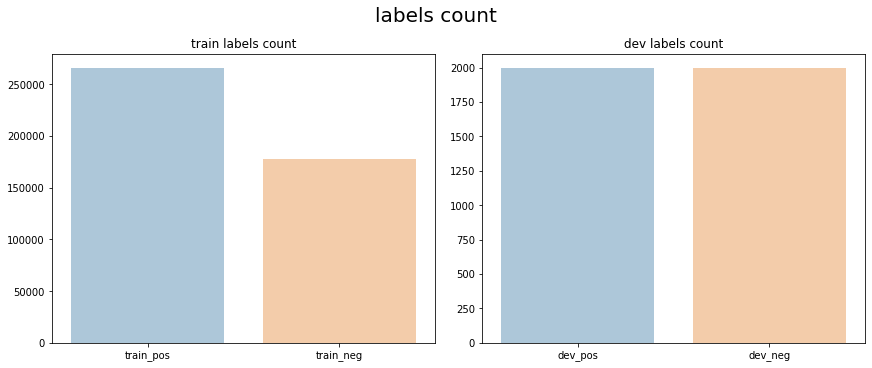

In [15]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5), constrained_layout = True)

g1 = sns.barplot(x = np.array(['train_pos', 'train_neg']),
                y = np.array([len(train_pos), len(train_neg)]),
                alpha = .4, ax = ax[0])
g1.set_title("train labels count")

g2 = sns.barplot(x = np.array(['dev_pos', 'dev_neg']),
                y = np.array([len(dev_pos), len(dev_neg)]),
                alpha = .4, ax = ax[1])
g2.set_title("dev labels count")

fig.suptitle('labels count', fontsize=20)
plt.show()

In [16]:
train_pos[:10]

['2 5977 950 13 9 3',
 '2 18656 7705 365 13 9 3',
 '2 59 67 57 1954 621 18 17 1392 5262 56 25 510 254 13 9 3',
 '2 32 13 22 18 21 254 13865 69 20538 7298 13 9 3',
 '2 14 1138 25 4753 13 9 3',
 '2 254 748 950 13 9 3',
 '2 254 365 13 9 3',
 '2 11554 16 208 25 27269 17 7503 16 621 18 13 9 3',
 '2 374 209 26 4311 54 748 16385 18 17 3911 13 9 3',
 '2 14 78 978 1879 5289 13 9 3']

In [17]:
class SentimentDataset(object):
    def __init__(self, tokenizer, pos, neg):
        self.tokenizer = tokenizer
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += [self._cast_to_int(pos_sent.strip().split())]
            self.label += [[1]]
        for neg_sent in neg:
            self.data += [self._cast_to_int(neg_sent.strip().split())]
            self.label += [[0]]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [18]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

## Small sample of dataset

- 데이터셋 일부만 사용하고 싶다면

In [67]:
if SMALL_SAMPLE == True:
    train_dataset_total = SentimentDataset(tokenizer, train_pos, train_neg)
    dev_dataset_total = SentimentDataset(tokenizer, dev_pos, dev_neg)

    train_dataset = random.sample(list(train_dataset_total), int(PERC * len(train_dataset_total)))
    dev_dataset = random.sample(list(dev_dataset_total), int(PERC * len(dev_dataset_total)))

    print(len(train_dataset_total))
    print(len(dev_dataset_total))
    print(len(train_dataset))
    print(len(dev_dataset))

    del train_dataset_total
    del dev_dataset_total
    gc.collect()

In [68]:
# train dataset 10개 인쇄
for i, item in enumerate(train_dataset):
    print(item)
    if i == 10:
        break

(array([    2,    75,    52,  3396,    51,  3820, 17253,  4905, 14973,
         645,    13,    15,    31,   227,    20, 10265,    13,     9,
           3]), array([0]))
(array([    2,    14,  6364,    25, 13706,    13,     9,     3]), array([1]))
(array([    2,    14,   950,    23, 10356,    28,   134,    13,    15,
        3433,    46, 15853,    20, 16275,    13,     9,     3]), array([1]))
(array([   2,   48,   25,   14,  246,  209,  462,   26,   13,   18, 9996,
         13,  187,    3]), array([1]))
(array([   2,   32,   25,  190, 1467,   17, 1783,   13,    9,    3]), array([1]))
(array([   2,  127,  148,  235,  143,  184,   20, 4481,   17, 2036,   70,
       2414, 3217,   13,    9,    3]), array([1]))
(array([    2,    31,   339, 23108,    13,   187,     3]), array([1]))
(array([   2,   14,  950,   23,  114,  193,   17,   14, 8128,   23, 2107,
         13,    9,    3]), array([1]))
(array([    2,    14,  2410,  6910,    35,   182,  1679,    51, 12497,
          23,  6210,    13,   

In [69]:
def collate_fn_style(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)
    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices], batch_first=True)
    attention_mask = torch.tensor([[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

# 2️⃣ Model: Training & Validation

In [70]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

## Hyperparameter Tuning using WandB 🐝

In [71]:
def build_optimizer(model, optimizer, learning_rate, weight_decay):
    if optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'adamw':
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    return optimizer

### ✅ Define sweep config

- sweep_configuration
```
CASE = 'Case3'
```
- [`method`](https://docs.wandb.ai/guides/sweeps/define-sweep-configuration#method)
```
'method': 'grid',
```
    - grid: Grid search iterates over all possible combinations of parameter values.
    - random: Random search chooses a random set of values on each iteration.
    - bayes: Our Bayesian hyperparameter search method uses a Gaussian Process to model the relationship between the parameters and the model metric and chooses parameters to optimize the probability of improvement. This strategy requires the metric key to be specified.

In [106]:
CASE = 'Case3' # 'Case1', 'Case2', 'Case3' 중 하나만

In [107]:
# 🐝 Step 1: Define sweep config
if CASE == 'Case1':
    MY_PARAMETERS = {
        'batch_size': {'values': [32]},
        'optimizer': {'values': ['adamw']},
        'lr': {'values': [1e-01, 1e-02, 1e-03, 1e-04, 1e-05]},
        'weight_decay': {'values': [0]},
        'epochs': {'values': [1]}
    }
elif CASE == 'Case2':
    MY_PARAMETERS = {
        'batch_size': {'values': [32,64,128]},
        'optimizer': {'values': ['adamw']},
        'lr': {'values': [ 1e-04, 1e-05]}, # {'max': 0.1, 'min': 0.0001}
        'weight_decay': {'values': [1e-04,1e-05,0]}, # {'max': 0.1, 'min': 0.0}
        'epochs': {'values': [1]} # {'values': [1]}
    }
elif CASE == 'Case3':
    MY_PARAMETERS = {
        'batch_size': {'values': [32,128]},
        'optimizer': {'values': ['adamw']},
        'lr': {'values': [1e-4,1e-05]}, # {'max': 0.1, 'min': 0.0001}
        'weight_decay': {'values': [0,0.0001]}, # {'max': 0.1, 'min': 0.0}
        'epochs': {'values': [1,3,5,10]} # {'values': [1]}
    }

sweep_configuration = {
    'method': 'grid', # 'random'
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': "val/val_accuracy"},
    'description': MY_MODEL_NAME,
    'parameters': MY_PARAMETERS
}

# 🐝 Step 2: Initialize sweep by passing in config
sweep_id = wandb.sweep(sweep=sweep_configuration, project=CASE)

Create sweep with ID: mqewsfcj
Sweep URL: https://wandb.ai/goorm/Case3/sweeps/mqewsfcj


### 🔴 Define Pretraind Language Model

- 원하는 모델이 if 문 안에 있는지 확인

In [108]:
print(MY_MODEL_NAME)

albert-base


### ✅

- [LOWEST_VAL_ACC]보다 크면 parameters 저장 → Checkpoint
```
LOWEST_VAL_ACC = 0.9
(중략)
                    if val_acc > LOWEST_VAL_ACC:
                        torch.save(model.state_dict(), my_name)
```
- 맨 마지막에 parameters 저장
```
    # 💾 학습이 완료되면 최종 parameters를 저장
    torch.save(model.state_dict(), my_name + '.bin')
```

In [109]:
# Choose whether to draw loss graph using Matplotlip
DRAW_GRAPH = True # 그래프를 그리고 싶다면
#DRAW_GRAPH = False # 그래프를 그리고 싶지 않다면

# Determine how many times to validate per epoch
VALID_INTERVAL = 5 # 5 (권장)

# Determine minimum validation accuracy
LOWEST_VAL_ACC = 0.9

In [110]:
# 🐝 Step 3: Define training function that takes in hyperparameter 
# values from `wandb.config` and uses them to train a model and return metric
def main():
    # 🐝 initialise a wandb run
    # Use the wandb.init() API to generate a background process 
    # to sync and log data as a Weights and Biases run.
    # Optionally provide the name of the project.
    # 🐝 initialise a wandb run
    run = wandb.init(project=CASE)

    # note that we define values from `wandb.config` instead of 
    # defining hard values
    batch_size = wandb.config.batch_size
    optim = wandb.config.optimizer
    lr  =  wandb.config.lr
    weight_decay = wandb.config.weight_decay
    epochs = wandb.config.epochs

    my_name = "model_" + MY_MODEL_NAME + "_" + str(batch_size) + "_" + str(optim) + "_" + str(lr) + "_" + str(weight_decay) + "_" + str(epochs)
    run.name = my_name

    # Get the data
    train_loader = torch.utils.data.DataLoader( # Train dataset
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn_style,
        pin_memory=True, num_workers=2)
    dev_loader = torch.utils.data.DataLoader( # Validation dataset
        dev_dataset,
        batch_size=batch_size*2,
        shuffle=False,
        collate_fn=collate_fn_style,
        num_workers=2)
    
    if MY_MODEL_NAME == 'bert-base': model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    elif MY_MODEL_NAME == 'bert-large': model = BertForSequenceClassification.from_pretrained('bert-large-uncased')
    elif MY_MODEL_NAME == 'albert-base': model = AlbertForSequenceClassification.from_pretrained("albert-base-v2")
    elif MY_MODEL_NAME == 'albert-large': model = AlbertForSequenceClassification.from_pretrained("albert-large-v2")
    model.to(device)

    # Make the loss and optimizer
    optimizer = build_optimizer(model, optim, lr, weight_decay)

     # 📈 For visualization using Matplotlib
    train_loss_history = []
    valid_loss_history = []

    # Training
    for epoch in range(epochs):
        with tqdm(train_loader, unit="batch") as tepoch:
            for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
                model.train()
                tepoch.set_description(f"Epoch {epoch}")
                
                # Train
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                token_type_ids = token_type_ids.to(device)
                position_ids = position_ids.to(device)
                labels = labels.to(device, dtype=torch.long)

                optimizer.zero_grad()
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    position_ids=position_ids,
                    labels=labels)
                train_loss = outputs.loss
                train_loss.backward()
                optimizer.step()
                
                # 🐝 Log train metrics to wandb 
                wandb.log({
                    "train/epoch": epoch,
                    "train/train_loss": train_loss
                })

                tepoch.set_postfix(loss=train_loss.item())

                if iteration != 0 and iteration % int(len(train_loader) / VALID_INTERVAL) == 0:
                    # Evaluate the model [VALID_INTERVAL] times per epoch
                    model.eval()
                    with torch.no_grad():
                        val_losses = []
                        predictions = []
                        target_labels = []
                        for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(
                            dev_loader,
                            desc='Eval',
                            position=1,
                            leave=None):
                            # Validation
                            input_ids = input_ids.to(device)
                            attention_mask = attention_mask.to(device)
                            token_type_ids = token_type_ids.to(device)
                            position_ids = position_ids.to(device)
                            labels = labels.to(device, dtype=torch.long)

                            outputs = model(
                                input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                position_ids=position_ids,
                                labels=labels)
                            loss = outputs.loss
                            logits = outputs.logits
                            val_losses.append(loss.item())

                            batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                            batch_labels = [int(example) for example in labels]

                            predictions += batch_predictions
                            target_labels += batch_labels
                    
                    val_loss = sum(val_losses) / len(val_losses)
                    val_acc = compute_acc(predictions, target_labels)

                    # 🐝 Log validation metrics to wandb
                    wandb.log({
                        "val/val_accuracy": val_acc,
                        "val/val_loss": val_loss
                    })
                    train_loss_history.append(train_loss)  # 📈 For visualization using Matplotlib
                    valid_loss_history.append(val_loss)  # 📈 For visualization using Matplotlib
                    print('=====> val_acc: ', val_acc)
                    
                    # 💾 [LOWEST_VAL_ACC]보다 크면 parameters 저장
                    if val_acc > LOWEST_VAL_ACC:
                        torch.save(model.state_dict(), my_name + '_ckp.bin') # checkpoint
                        print('\nSaved the model!')

    # 💾 학습이 완료되면 최종 parameters를 저장
    torch.save(model.state_dict(), my_name + '.bin')

    if DRAW_GRAPH:
        # 📈 For visualization using Matplotlib
        # 간단하게 train loss & validation loss 시각화
        train_loss_history = torch.tensor(train_loss_history).detach().cpu().numpy()
        valid_loss_history = torch.tensor(valid_loss_history).detach().cpu().numpy()
        plt.plot(train_loss_history, label = "Train Loss")
        plt.plot(valid_loss_history, label = "Validation Loss")
        plt.title('Loss (' + my_name + ')')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(my_name + '.png') # 💾
        plt.close()

- [`wnadb.agent`](https://docs.wandb.ai/ref/python/agent)
    - count
(int, optional) the number of trials to run.

In [111]:
# 🐝 Step 4: Call to `wandb.agent` to start a sweep
wandb.agent(sweep_id, function=main)

wandb: Agent Starting Run: jlhe3e1q with config:
wandb: 	batch_size: 32
wandb: 	epochs: 1
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.35


Epoch 0:  41%|████      | 57/139 [00:03<00:07, 11.46batch/s, loss=0.714]

=====> val_acc:  0.35


Epoch 0:  60%|██████    | 84/139 [00:05<00:04, 12.80batch/s, loss=0.642]

=====> val_acc:  0.35


Epoch 0:  80%|███████▉  | 111/139 [00:07<00:02, 12.59batch/s, loss=0.741]

=====> val_acc:  0.35


Epoch 0:  99%|█████████▉| 138/139 [00:08<00:00, 12.72batch/s, loss=0.749]

=====> val_acc:  0.35


Epoch 0: 100%|██████████| 139/139 [00:08<00:00, 15.94batch/s, loss=0.749]


wandb: Agent Starting Run: wwyrdvya with config:
wandb: 	batch_size: 32
wandb: 	epochs: 1
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.35


Epoch 0:  41%|████      | 57/139 [00:03<00:06, 13.46batch/s, loss=0.638]

=====> val_acc:  0.35


Epoch 0:  60%|██████    | 84/139 [00:05<00:04, 12.66batch/s, loss=0.589]

=====> val_acc:  0.35


Epoch 0:  81%|████████  | 112/139 [00:06<00:01, 13.66batch/s, loss=0.697]

=====> val_acc:  0.35


Epoch 0: 100%|██████████| 139/139 [00:08<00:00, 14.17batch/s, loss=0.738]

=====> val_acc:  0.35


Epoch 0: 100%|██████████| 139/139 [00:08<00:00, 16.26batch/s, loss=0.738]


wandb: Agent Starting Run: w0jvn8wa with config:
wandb: 	batch_size: 32
wandb: 	epochs: 1
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.425


Epoch 0:  41%|████      | 57/139 [00:03<00:06, 12.47batch/s, loss=0.575]

=====> val_acc:  0.425


Epoch 0:  60%|██████    | 84/139 [00:05<00:04, 13.29batch/s, loss=0.643]

=====> val_acc:  0.65


Epoch 0:  80%|███████▉  | 111/139 [00:06<00:02, 12.62batch/s, loss=0.273]

=====> val_acc:  0.9


Epoch 0:  99%|█████████▊| 137/139 [00:08<00:00, 11.11batch/s, loss=0.0669]

=====> val_acc:  0.925

Saved the model!


Epoch 0: 100%|██████████| 139/139 [00:08<00:00, 16.09batch/s, loss=0.0841]


wandb: Agent Starting Run: jmos9jmm with config:
wandb: 	batch_size: 32
wandb: 	epochs: 1
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.425


Epoch 0:  42%|████▏     | 58/139 [00:03<00:05, 13.66batch/s, loss=0.711]

=====> val_acc:  0.4


Epoch 0:  60%|██████    | 84/139 [00:05<00:04, 12.38batch/s, loss=0.682]

=====> val_acc:  0.375


Epoch 0:  80%|███████▉  | 111/139 [00:06<00:02, 12.59batch/s, loss=0.716]

=====> val_acc:  0.375


Epoch 0:  99%|█████████▉| 138/139 [00:08<00:00, 12.67batch/s, loss=0.726]

=====> val_acc:  0.375


Epoch 0: 100%|██████████| 139/139 [00:08<00:00, 16.26batch/s, loss=0.726]


wandb: Agent Starting Run: a9kpaqfi with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.35


Epoch 0:  42%|████▏     | 58/139 [00:03<00:05, 13.99batch/s, loss=0.805]

=====> val_acc:  0.35


Epoch 0:  60%|██████    | 84/139 [00:05<00:04, 12.63batch/s, loss=0.761]

=====> val_acc:  0.35


Epoch 0:  80%|███████▉  | 111/139 [00:06<00:02, 12.60batch/s, loss=0.645]

=====> val_acc:  0.35


Epoch 0:  99%|█████████▉| 138/139 [00:08<00:00, 12.43batch/s, loss=0.681]

=====> val_acc:  0.35


Epoch 1:  22%|██▏       | 30/139 [00:02<00:08, 12.43batch/s, loss=0.688]

=====> val_acc:  0.35


Epoch 1:  40%|████      | 56/139 [00:03<00:06, 12.46batch/s, loss=0.631]

=====> val_acc:  0.35


Epoch 1:  62%|██████▏   | 86/139 [00:05<00:03, 14.14batch/s, loss=0.68]

=====> val_acc:  0.35


Epoch 1:  80%|███████▉  | 111/139 [00:06<00:02, 13.52batch/s, loss=0.629]

=====> val_acc:  0.35


Epoch 1:  99%|█████████▉| 138/139 [00:08<00:00, 12.72batch/s, loss=0.661]

=====> val_acc:  0.575


Epoch 2:  23%|██▎       | 32/139 [00:02<00:07, 14.24batch/s, loss=0.68]

=====> val_acc:  0.35


Epoch 2:  42%|████▏     | 59/139 [00:03<00:05, 14.07batch/s, loss=0.709]

=====> val_acc:  0.65


Epoch 2:  60%|██████    | 84/139 [00:05<00:04, 13.67batch/s, loss=0.697]

=====> val_acc:  0.35


Epoch 2:  80%|███████▉  | 111/139 [00:06<00:02, 12.45batch/s, loss=0.643]

=====> val_acc:  0.35


Epoch 2:  99%|█████████▉| 138/139 [00:08<00:00, 12.71batch/s, loss=0.697]

=====> val_acc:  0.35


Epoch 2: 100%|██████████| 139/139 [00:08<00:00, 16.35batch/s, loss=0.697]


wandb: Agent Starting Run: 68eeyq5j with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.35


Epoch 0:  41%|████      | 57/139 [00:03<00:06, 12.28batch/s, loss=0.284]

=====> val_acc:  0.925

Saved the model!


Epoch 0:  60%|██████    | 84/139 [00:05<00:04, 11.43batch/s, loss=0.544]

=====> val_acc:  0.975

Saved the model!


Epoch 0:  80%|███████▉  | 111/139 [00:07<00:02, 12.30batch/s, loss=0.406]

=====> val_acc:  0.8


Epoch 0:  99%|█████████▉| 138/139 [00:08<00:00, 12.70batch/s, loss=0.168]

=====> val_acc:  0.9


Epoch 1:  22%|██▏       | 30/139 [00:01<00:08, 13.50batch/s, loss=0.417]

=====> val_acc:  0.9


Epoch 1:  40%|████      | 56/139 [00:03<00:07, 11.00batch/s, loss=0.181]

=====> val_acc:  0.95

Saved the model!


Epoch 1:  62%|██████▏   | 86/139 [00:05<00:03, 14.06batch/s, loss=0.189]

=====> val_acc:  0.875


Epoch 1:  80%|███████▉  | 111/139 [00:06<00:02, 12.51batch/s, loss=0.274]

=====> val_acc:  0.95

Saved the model!


Epoch 1:  99%|█████████▊| 137/139 [00:08<00:00, 11.52batch/s, loss=0.135]

=====> val_acc:  0.925

Saved the model!


Epoch 2:  22%|██▏       | 30/139 [00:01<00:08, 12.61batch/s, loss=0.0534]

=====> val_acc:  0.9


Epoch 2:  41%|████      | 57/139 [00:03<00:06, 12.42batch/s, loss=0.0975]

=====> val_acc:  0.9


Epoch 2:  58%|█████▊    | 81/139 [00:05<00:02, 20.18batch/s, loss=0.237]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  79%|███████▉  | 110/139 [00:06<00:02, 11.26batch/s, loss=0.112]

=====> val_acc:  0.925

Saved the model!


Epoch 2:  99%|█████████▊| 137/139 [00:08<00:00, 12.68batch/s, loss=0.606]

=====> val_acc:  0.625


Epoch 2: 100%|██████████| 139/139 [00:08<00:00, 16.02batch/s, loss=0.606]


wandb: Agent Starting Run: iwmrlskb with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.425


Epoch 0:  41%|████      | 57/139 [00:03<00:06, 12.43batch/s, loss=0.631]

=====> val_acc:  0.4


Epoch 0:  60%|██████    | 84/139 [00:05<00:04, 13.49batch/s, loss=0.705]

=====> val_acc:  0.4


Epoch 0:  80%|███████▉  | 111/139 [00:06<00:02, 13.56batch/s, loss=0.521]

=====> val_acc:  0.5


Epoch 0:  99%|█████████▊| 137/139 [00:08<00:00, 12.48batch/s, loss=0.275]

=====> val_acc:  0.7


Epoch 1:  20%|██        | 28/139 [00:02<00:10, 10.22batch/s, loss=0.212]

=====> val_acc:  0.975

Saved the model!


Epoch 1:  41%|████      | 57/139 [00:03<00:07, 11.23batch/s, loss=0.113]

=====> val_acc:  1.0

Saved the model!


Epoch 1:  61%|██████    | 85/139 [00:05<00:04, 13.47batch/s, loss=0.339]

=====> val_acc:  0.9


Epoch 1:  80%|███████▉  | 111/139 [00:07<00:02, 12.45batch/s, loss=0.0525]

=====> val_acc:  0.925

Saved the model!


Epoch 1:  99%|█████████▊| 137/139 [00:08<00:00, 11.36batch/s, loss=0.123]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  21%|██        | 29/139 [00:02<00:11,  9.91batch/s, loss=0.0847]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  42%|████▏     | 59/139 [00:04<00:05, 13.40batch/s, loss=0.688]

=====> val_acc:  0.35


Epoch 2:  60%|██████    | 84/139 [00:05<00:04, 12.47batch/s, loss=0.642]

=====> val_acc:  0.35


Epoch 2:  80%|███████▉  | 111/139 [00:07<00:02, 13.33batch/s, loss=0.673]

=====> val_acc:  0.35


Epoch 2: 100%|██████████| 139/139 [00:09<00:00, 14.08batch/s, loss=0.486]

=====> val_acc:  0.55


Epoch 2: 100%|██████████| 139/139 [00:09<00:00, 15.19batch/s, loss=0.486]


wandb: Agent Starting Run: qftp4z7k with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.4


Epoch 0:  41%|████      | 57/139 [00:03<00:06, 12.22batch/s, loss=0.524]

=====> val_acc:  0.45


Epoch 0:  61%|██████    | 85/139 [00:05<00:03, 13.52batch/s, loss=0.524]

=====> val_acc:  0.675


Epoch 0:  80%|███████▉  | 111/139 [00:06<00:02, 10.81batch/s, loss=0.171]

=====> val_acc:  0.95

Saved the model!


Epoch 0:  99%|█████████▊| 137/139 [00:08<00:00, 10.04batch/s, loss=0.136]

=====> val_acc:  0.975

Saved the model!


Epoch 1:  21%|██        | 29/139 [00:02<00:10, 10.96batch/s, loss=0.0655]

=====> val_acc:  0.925

Saved the model!


Epoch 1:  41%|████      | 57/139 [00:03<00:07, 11.15batch/s, loss=0.0299]

=====> val_acc:  0.95

Saved the model!


Epoch 1:  60%|█████▉    | 83/139 [00:05<00:05, 10.98batch/s, loss=0.0974]

=====> val_acc:  0.95

Saved the model!


Epoch 1:  80%|███████▉  | 111/139 [00:07<00:02, 12.31batch/s, loss=0.231]

=====> val_acc:  0.975

Saved the model!


Epoch 1:  99%|█████████▊| 137/139 [00:08<00:00,  9.03batch/s, loss=0.0292]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  21%|██        | 29/139 [00:02<00:12,  8.79batch/s, loss=0.0937]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  41%|████      | 57/139 [00:03<00:07, 11.00batch/s, loss=0.119]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  60%|██████    | 84/139 [00:05<00:04, 11.31batch/s, loss=0.0707]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  79%|███████▉  | 110/139 [00:07<00:02, 10.86batch/s, loss=0.0325]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  99%|█████████▉| 138/139 [00:08<00:00, 12.40batch/s, loss=0.124]

=====> val_acc:  1.0

Saved the model!


Epoch 2: 100%|██████████| 139/139 [00:09<00:00, 15.21batch/s, loss=0.0303]


wandb: Agent Starting Run: em6x3axh with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.65


Epoch 0:  41%|████      | 57/139 [00:03<00:06, 12.38batch/s, loss=0.73]

=====> val_acc:  0.35


Epoch 0:  60%|██████    | 84/139 [00:05<00:04, 12.46batch/s, loss=0.606]

=====> val_acc:  0.35


Epoch 0:  80%|███████▉  | 111/139 [00:06<00:02, 12.60batch/s, loss=0.721]

=====> val_acc:  0.35


Epoch 0:  99%|█████████▉| 138/139 [00:08<00:00, 12.60batch/s, loss=0.728]

=====> val_acc:  0.35


Epoch 1:  23%|██▎       | 32/139 [00:02<00:07, 14.19batch/s, loss=0.698]

=====> val_acc:  0.35


Epoch 1:  41%|████      | 57/139 [00:03<00:05, 13.87batch/s, loss=0.664]

=====> val_acc:  0.35


Epoch 1:  60%|██████    | 84/139 [00:05<00:04, 12.26batch/s, loss=0.63]

=====> val_acc:  0.35


Epoch 1:  80%|███████▉  | 111/139 [00:06<00:02, 12.42batch/s, loss=0.692]

=====> val_acc:  0.35


Epoch 1:  99%|█████████▊| 137/139 [00:08<00:00, 12.43batch/s, loss=0.641]

=====> val_acc:  0.35


Epoch 2:  22%|██▏       | 30/139 [00:02<00:09, 12.10batch/s, loss=0.703]

=====> val_acc:  0.35


Epoch 2:  41%|████      | 57/139 [00:03<00:06, 12.51batch/s, loss=0.732]

=====> val_acc:  0.35


Epoch 2:  62%|██████▏   | 86/139 [00:05<00:03, 14.13batch/s, loss=0.693]

=====> val_acc:  0.35


Epoch 2:  81%|████████  | 112/139 [00:06<00:01, 13.52batch/s, loss=0.72]

=====> val_acc:  0.35


Epoch 2:  99%|█████████▉| 138/139 [00:08<00:00, 12.68batch/s, loss=0.767]

=====> val_acc:  0.35


Epoch 3:  22%|██▏       | 30/139 [00:02<00:08, 13.59batch/s, loss=0.66]

=====> val_acc:  0.35


Epoch 3:  42%|████▏     | 58/139 [00:03<00:06, 13.48batch/s, loss=0.705]

=====> val_acc:  0.35


Epoch 3:  61%|██████    | 85/139 [00:05<00:03, 14.23batch/s, loss=0.704]

=====> val_acc:  0.35


Epoch 3:  81%|████████  | 112/139 [00:06<00:01, 14.28batch/s, loss=0.624]

=====> val_acc:  0.35


Epoch 3:  99%|█████████▉| 138/139 [00:08<00:00, 12.59batch/s, loss=0.699]

=====> val_acc:  0.35


Epoch 4:  22%|██▏       | 30/139 [00:02<00:08, 12.51batch/s, loss=0.627]

=====> val_acc:  0.35


Epoch 4:  41%|████      | 57/139 [00:03<00:06, 12.29batch/s, loss=0.657]

=====> val_acc:  0.35


Epoch 4:  62%|██████▏   | 86/139 [00:05<00:03, 14.02batch/s, loss=0.616]

=====> val_acc:  0.35


Epoch 4:  80%|███████▉  | 111/139 [00:06<00:02, 13.66batch/s, loss=0.648]

=====> val_acc:  0.35


Epoch 4:  99%|█████████▊| 137/139 [00:08<00:00, 12.51batch/s, loss=0.758]

=====> val_acc:  0.35


Epoch 4: 100%|██████████| 139/139 [00:08<00:00, 16.35batch/s, loss=0.758]


wandb: Agent Starting Run: gklrjws4 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.375


Epoch 0:  42%|████▏     | 59/139 [00:03<00:05, 13.42batch/s, loss=0.694]

=====> val_acc:  0.375


Epoch 0:  60%|██████    | 84/139 [00:05<00:04, 12.48batch/s, loss=0.653]

=====> val_acc:  0.375


Epoch 0:  80%|███████▉  | 111/139 [00:06<00:02, 12.30batch/s, loss=0.681]

=====> val_acc:  0.375


Epoch 0: 100%|██████████| 139/139 [00:08<00:00, 14.04batch/s, loss=0.626]

=====> val_acc:  0.35


Epoch 1:  22%|██▏       | 30/139 [00:02<00:08, 12.24batch/s, loss=0.676]

=====> val_acc:  0.375


Epoch 1:  42%|████▏     | 58/139 [00:03<00:06, 13.07batch/s, loss=0.733]

=====> val_acc:  0.425


Epoch 1:  60%|██████    | 84/139 [00:05<00:04, 12.44batch/s, loss=0.681]

=====> val_acc:  0.375


Epoch 1:  80%|███████▉  | 111/139 [00:06<00:02, 13.57batch/s, loss=0.652]

=====> val_acc:  0.375


Epoch 1: 100%|██████████| 139/139 [00:08<00:00, 14.29batch/s, loss=0.638]

=====> val_acc:  0.375


Epoch 2:  22%|██▏       | 30/139 [00:02<00:08, 12.26batch/s, loss=0.616]

=====> val_acc:  0.375


Epoch 2:  42%|████▏     | 58/139 [00:03<00:06, 13.44batch/s, loss=0.75]

=====> val_acc:  0.375


Epoch 2:  60%|██████    | 84/139 [00:05<00:03, 13.84batch/s, loss=0.659]

=====> val_acc:  0.375


Epoch 2:  81%|████████▏ | 113/139 [00:06<00:01, 14.21batch/s, loss=0.639]

=====> val_acc:  0.675


Epoch 2:  99%|█████████▉| 138/139 [00:08<00:00, 13.65batch/s, loss=0.673]

=====> val_acc:  0.425


Epoch 3:  22%|██▏       | 30/139 [00:02<00:08, 13.46batch/s, loss=0.516]

=====> val_acc:  0.7


Epoch 3:  41%|████      | 57/139 [00:03<00:06, 13.47batch/s, loss=0.62] 

=====> val_acc:  0.35


Epoch 3:  60%|██████    | 84/139 [00:05<00:04, 12.47batch/s, loss=0.821]

=====> val_acc:  0.35


Epoch 3:  80%|███████▉  | 111/139 [00:06<00:02, 12.55batch/s, loss=0.652]

=====> val_acc:  0.35


Epoch 3:  99%|█████████▉| 138/139 [00:08<00:00, 12.51batch/s, loss=0.714]

=====> val_acc:  0.35


Epoch 4:  22%|██▏       | 30/139 [00:02<00:08, 13.14batch/s, loss=0.696]

=====> val_acc:  0.35


Epoch 4:  41%|████      | 57/139 [00:03<00:06, 12.46batch/s, loss=0.61]

=====> val_acc:  0.35


Epoch 4:  61%|██████    | 85/139 [00:05<00:04, 13.28batch/s, loss=0.657]

=====> val_acc:  0.35


Epoch 4:  80%|███████▉  | 111/139 [00:06<00:02, 13.45batch/s, loss=0.776]

=====> val_acc:  0.35


Epoch 4:  99%|█████████▉| 138/139 [00:08<00:00, 12.73batch/s, loss=0.678]

=====> val_acc:  0.35


Epoch 4: 100%|██████████| 139/139 [00:08<00:00, 16.18batch/s, loss=0.678]


wandb: Agent Starting Run: zf9rue8t with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.475


Epoch 0:  41%|████      | 57/139 [00:03<00:06, 13.01batch/s, loss=0.335]

=====> val_acc:  0.75


Epoch 0:  60%|██████    | 84/139 [00:05<00:04, 11.17batch/s, loss=0.12]

=====> val_acc:  0.95

Saved the model!


Epoch 0:  80%|███████▉  | 111/139 [00:07<00:02, 11.08batch/s, loss=0.296]

=====> val_acc:  1.0

Saved the model!


Epoch 0:  99%|█████████▊| 137/139 [00:08<00:00, 11.12batch/s, loss=0.172]

=====> val_acc:  1.0

Saved the model!


Epoch 1:  20%|██        | 28/139 [00:02<00:10, 10.79batch/s, loss=0.0567]

=====> val_acc:  0.925

Saved the model!


Epoch 1:  41%|████      | 57/139 [00:03<00:07, 11.12batch/s, loss=0.0954]

=====> val_acc:  0.975

Saved the model!


Epoch 1:  60%|██████    | 84/139 [00:05<00:04, 12.40batch/s, loss=0.0209]

=====> val_acc:  0.975

Saved the model!


Epoch 1:  80%|███████▉  | 111/139 [00:07<00:02, 11.19batch/s, loss=0.0873]

=====> val_acc:  1.0

Saved the model!


Epoch 1:  98%|█████████▊| 136/139 [00:08<00:00, 10.40batch/s, loss=0.0483]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  20%|██        | 28/139 [00:02<00:10, 10.90batch/s, loss=0.155]

=====> val_acc:  1.0

Saved the model!


Epoch 2:  41%|████      | 57/139 [00:03<00:07, 11.28batch/s, loss=0.0787]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  60%|██████    | 84/139 [00:05<00:04, 11.18batch/s, loss=0.182]

=====> val_acc:  0.925

Saved the model!


Epoch 2:  80%|███████▉  | 111/139 [00:07<00:02, 11.24batch/s, loss=0.157]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  99%|█████████▊| 137/139 [00:08<00:00, 11.20batch/s, loss=0.0288]

=====> val_acc:  0.975

Saved the model!


Epoch 3:  21%|██        | 29/139 [00:02<00:10, 10.63batch/s, loss=0.0081]

=====> val_acc:  0.975

Saved the model!


Epoch 3:  41%|████      | 57/139 [00:03<00:07, 10.93batch/s, loss=0.0402]

=====> val_acc:  1.0

Saved the model!


Epoch 3:  60%|█████▉    | 83/139 [00:05<00:05, 11.00batch/s, loss=0.131]

=====> val_acc:  1.0

Saved the model!


Epoch 3:  80%|███████▉  | 111/139 [00:07<00:02, 11.05batch/s, loss=0.0153]

=====> val_acc:  1.0

Saved the model!


Epoch 3:  99%|█████████▉| 138/139 [00:08<00:00, 11.46batch/s, loss=0.126]

=====> val_acc:  1.0

Saved the model!


Epoch 4:  21%|██        | 29/139 [00:02<00:10, 10.71batch/s, loss=0.00877]

=====> val_acc:  1.0

Saved the model!


Epoch 4:  41%|████      | 57/139 [00:03<00:06, 11.72batch/s, loss=0.00834]

=====> val_acc:  1.0

Saved the model!


Epoch 4:  60%|█████▉    | 83/139 [00:05<00:04, 11.29batch/s, loss=0.0297]

=====> val_acc:  1.0

Saved the model!


Epoch 4:  79%|███████▉  | 110/139 [00:07<00:02, 11.08batch/s, loss=0.00453]

=====> val_acc:  1.0

Saved the model!


Epoch 4:  99%|█████████▉| 138/139 [00:08<00:00, 11.17batch/s, loss=0.00512]

=====> val_acc:  1.0

Saved the model!


Epoch 4: 100%|██████████| 139/139 [00:09<00:00, 15.38batch/s, loss=0.0568]


wandb: Agent Starting Run: 2kyjp3hb with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.45


Epoch 0:  42%|████▏     | 59/139 [00:03<00:05, 13.49batch/s, loss=0.445]

=====> val_acc:  0.7


Epoch 0:  59%|█████▉    | 82/139 [00:05<00:05, 11.09batch/s, loss=0.261]

=====> val_acc:  0.925

Saved the model!


Epoch 0:  80%|███████▉  | 111/139 [00:07<00:02, 12.32batch/s, loss=0.0561]

=====> val_acc:  0.9


Epoch 0:  99%|█████████▊| 137/139 [00:08<00:00, 10.71batch/s, loss=0.0503]

=====> val_acc:  0.95

Saved the model!


Epoch 1:  20%|██        | 28/139 [00:02<00:10, 10.76batch/s, loss=0.185]

=====> val_acc:  0.975

Saved the model!


Epoch 1:  41%|████      | 57/139 [00:03<00:07, 11.14batch/s, loss=0.19]

=====> val_acc:  0.975

Saved the model!


Epoch 1:  60%|█████▉    | 83/139 [00:05<00:04, 11.23batch/s, loss=0.04]

=====> val_acc:  0.975

Saved the model!


Epoch 1:  79%|███████▉  | 110/139 [00:07<00:02, 11.11batch/s, loss=0.226]

=====> val_acc:  0.975

Saved the model!


Epoch 1:  99%|█████████▉| 138/139 [00:08<00:00, 11.41batch/s, loss=0.225]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  21%|██        | 29/139 [00:02<00:10, 10.87batch/s, loss=0.0194]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  40%|████      | 56/139 [00:03<00:07, 11.28batch/s, loss=0.0232]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  60%|██████    | 84/139 [00:05<00:04, 11.11batch/s, loss=0.174]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  79%|███████▉  | 110/139 [00:07<00:02, 11.15batch/s, loss=0.0116]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  99%|█████████▉| 138/139 [00:08<00:00, 12.46batch/s, loss=0.0205]

=====> val_acc:  1.0

Saved the model!


Epoch 3:  21%|██        | 29/139 [00:02<00:11,  9.96batch/s, loss=0.104]

=====> val_acc:  1.0

Saved the model!


Epoch 3:  41%|████      | 57/139 [00:03<00:06, 12.16batch/s, loss=0.0173]

=====> val_acc:  0.95

Saved the model!


Epoch 3:  60%|██████    | 84/139 [00:05<00:04, 11.25batch/s, loss=0.0724]

=====> val_acc:  0.975

Saved the model!


Epoch 3:  80%|███████▉  | 111/139 [00:07<00:02, 11.35batch/s, loss=0.0236]

=====> val_acc:  0.975

Saved the model!


Epoch 3:  99%|█████████▊| 137/139 [00:08<00:00, 11.32batch/s, loss=0.144]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  19%|█▉        | 27/139 [00:02<00:05, 20.28batch/s, loss=0.028]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  41%|████      | 57/139 [00:03<00:07, 10.89batch/s, loss=0.00683]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  60%|██████    | 84/139 [00:05<00:04, 11.24batch/s, loss=0.00679]

=====> val_acc:  0.95

Saved the model!


Epoch 4:  80%|███████▉  | 111/139 [00:07<00:02, 11.17batch/s, loss=0.00636]

=====> val_acc:  0.95

Saved the model!


Epoch 4:  99%|█████████▉| 138/139 [00:08<00:00, 12.20batch/s, loss=0.0141]

=====> val_acc:  0.975

Saved the model!


Epoch 4: 100%|██████████| 139/139 [00:09<00:00, 15.40batch/s, loss=0.0078]


wandb: Agent Starting Run: fildasag with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.9


Epoch 0:  42%|████▏     | 58/139 [00:03<00:06, 13.41batch/s, loss=0.646]

=====> val_acc:  0.45


Epoch 0:  60%|██████    | 84/139 [00:05<00:04, 12.32batch/s, loss=0.162]

=====> val_acc:  0.85


Epoch 0:  80%|███████▉  | 111/139 [00:06<00:02, 11.24batch/s, loss=0.292]

=====> val_acc:  0.975

Saved the model!


Epoch 0:  99%|█████████▉| 138/139 [00:08<00:00, 12.39batch/s, loss=0.498]

=====> val_acc:  0.8


Epoch 1:  20%|██        | 28/139 [00:02<00:10, 10.83batch/s, loss=0.165]

=====> val_acc:  0.975

Saved the model!


Epoch 1:  41%|████      | 57/139 [00:03<00:07, 11.33batch/s, loss=0.108]

=====> val_acc:  0.925

Saved the model!


Epoch 1:  60%|██████    | 84/139 [00:05<00:04, 12.05batch/s, loss=0.113]

=====> val_acc:  0.925

Saved the model!


Epoch 1:  80%|███████▉  | 111/139 [00:07<00:02, 11.27batch/s, loss=0.113]

=====> val_acc:  0.95

Saved the model!


Epoch 1:  99%|█████████▊| 137/139 [00:08<00:00, 11.26batch/s, loss=0.25]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  20%|██        | 28/139 [00:02<00:10, 10.87batch/s, loss=0.256]

=====> val_acc:  1.0

Saved the model!


Epoch 2:  41%|████      | 57/139 [00:03<00:06, 12.23batch/s, loss=0.125]

=====> val_acc:  1.0

Saved the model!


Epoch 2:  60%|█████▉    | 83/139 [00:05<00:05, 11.05batch/s, loss=0.21]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  79%|███████▉  | 110/139 [00:07<00:02, 11.14batch/s, loss=0.102]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  99%|█████████▉| 138/139 [00:08<00:00, 11.34batch/s, loss=0.4]

=====> val_acc:  0.95

Saved the model!


Epoch 3:  22%|██▏       | 30/139 [00:02<00:08, 13.00batch/s, loss=0.217]

=====> val_acc:  0.9


Epoch 3:  41%|████      | 57/139 [00:03<00:06, 13.57batch/s, loss=0.786]

=====> val_acc:  0.35


Epoch 3:  61%|██████    | 85/139 [00:05<00:03, 13.52batch/s, loss=0.74] 

=====> val_acc:  0.35


Epoch 3:  80%|███████▉  | 111/139 [00:06<00:02, 13.69batch/s, loss=0.654]

=====> val_acc:  0.35


Epoch 3:  99%|█████████▊| 137/139 [00:08<00:00, 12.42batch/s, loss=0.525]

=====> val_acc:  0.35


Epoch 4:  22%|██▏       | 30/139 [00:02<00:08, 12.42batch/s, loss=0.51] 

=====> val_acc:  0.55


Epoch 4:  42%|████▏     | 59/139 [00:03<00:05, 14.17batch/s, loss=0.442]

=====> val_acc:  0.85


Epoch 4:  60%|██████    | 84/139 [00:05<00:04, 13.61batch/s, loss=0.419]

=====> val_acc:  0.825


Epoch 4:  80%|███████▉  | 111/139 [00:06<00:02, 12.48batch/s, loss=0.729]

=====> val_acc:  0.675


Epoch 4:  99%|█████████▉| 138/139 [00:08<00:00, 13.64batch/s, loss=0.606]

=====> val_acc:  0.35


Epoch 5:  22%|██▏       | 30/139 [00:02<00:08, 12.39batch/s, loss=0.673]

=====> val_acc:  0.35


Epoch 5:  41%|████      | 57/139 [00:03<00:06, 13.57batch/s, loss=0.658]

=====> val_acc:  0.35


Epoch 5:  62%|██████▏   | 86/139 [00:05<00:03, 14.39batch/s, loss=0.701]

=====> val_acc:  0.35


Epoch 5:  81%|████████▏ | 113/139 [00:06<00:01, 14.28batch/s, loss=0.68]

=====> val_acc:  0.35


Epoch 5:  99%|█████████▊| 137/139 [00:08<00:00, 12.60batch/s, loss=0.696]

=====> val_acc:  0.35


Epoch 6:  22%|██▏       | 30/139 [00:02<00:08, 13.26batch/s, loss=0.655]

=====> val_acc:  0.35


Epoch 6:  42%|████▏     | 58/139 [00:03<00:05, 13.64batch/s, loss=0.702]

=====> val_acc:  0.35


Epoch 6:  60%|██████    | 84/139 [00:05<00:04, 13.63batch/s, loss=0.693]

=====> val_acc:  0.35


Epoch 6:  79%|███████▉  | 110/139 [00:06<00:02, 12.39batch/s, loss=0.689]

=====> val_acc:  0.35


Epoch 6:  99%|█████████▊| 137/139 [00:08<00:00, 12.46batch/s, loss=0.703]

=====> val_acc:  0.35


Epoch 7:  22%|██▏       | 30/139 [00:01<00:08, 12.53batch/s, loss=0.628]

=====> val_acc:  0.35


Epoch 7:  42%|████▏     | 59/139 [00:03<00:05, 14.06batch/s, loss=0.703]

=====> val_acc:  0.35


Epoch 7:  62%|██████▏   | 86/139 [00:05<00:03, 14.33batch/s, loss=0.698]

=====> val_acc:  0.35


Epoch 7:  80%|███████▉  | 111/139 [00:06<00:02, 13.68batch/s, loss=0.704]

=====> val_acc:  0.35


Epoch 7:  99%|█████████▉| 138/139 [00:08<00:00, 12.45batch/s, loss=0.72] 

=====> val_acc:  0.35


Epoch 8:  22%|██▏       | 31/139 [00:02<00:07, 14.15batch/s, loss=0.688]

=====> val_acc:  0.35


Epoch 8:  41%|████      | 57/139 [00:03<00:06, 13.53batch/s, loss=0.716]

=====> val_acc:  0.35


Epoch 8:  60%|██████    | 84/139 [00:05<00:04, 12.41batch/s, loss=0.644]

=====> val_acc:  0.35


Epoch 8:  81%|████████  | 112/139 [00:06<00:01, 13.51batch/s, loss=0.715]

=====> val_acc:  0.35


Epoch 8: 100%|██████████| 139/139 [00:08<00:00, 14.49batch/s, loss=0.734]

=====> val_acc:  0.35


Epoch 9:  23%|██▎       | 32/139 [00:02<00:07, 13.86batch/s, loss=0.678]

=====> val_acc:  0.35


Epoch 9:  42%|████▏     | 59/139 [00:03<00:05, 14.00batch/s, loss=0.672]

=====> val_acc:  0.35


Epoch 9:  60%|██████    | 84/139 [00:05<00:04, 12.52batch/s, loss=0.72]

=====> val_acc:  0.35


Epoch 9:  81%|████████  | 112/139 [00:06<00:02, 13.40batch/s, loss=0.649]

=====> val_acc:  0.35


Epoch 9:  99%|█████████▉| 138/139 [00:08<00:00, 13.71batch/s, loss=0.735]

=====> val_acc:  0.35


Epoch 9: 100%|██████████| 139/139 [00:08<00:00, 16.20batch/s, loss=0.735]


wandb: Agent Starting Run: ssd79j5d with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.35


Epoch 0:  41%|████      | 57/139 [00:03<00:06, 12.80batch/s, loss=0.693]

=====> val_acc:  0.375


Epoch 0:  60%|██████    | 84/139 [00:05<00:04, 13.40batch/s, loss=0.677]

=====> val_acc:  0.425


Epoch 0:  81%|████████▏ | 113/139 [00:07<00:01, 14.11batch/s, loss=0.583]

=====> val_acc:  0.375


Epoch 0: 100%|██████████| 139/139 [00:08<00:00, 14.20batch/s, loss=0.659]

=====> val_acc:  0.35


Epoch 1:  22%|██▏       | 31/139 [00:02<00:08, 12.92batch/s, loss=0.745]

=====> val_acc:  0.35


Epoch 1:  41%|████      | 57/139 [00:03<00:05, 13.74batch/s, loss=0.682]

=====> val_acc:  0.35


Epoch 1:  60%|██████    | 84/139 [00:05<00:04, 13.58batch/s, loss=0.613]

=====> val_acc:  0.35


Epoch 1:  80%|███████▉  | 111/139 [00:06<00:02, 12.36batch/s, loss=0.64]

=====> val_acc:  0.35


Epoch 1:  99%|█████████▊| 137/139 [00:08<00:00, 12.71batch/s, loss=0.646]

=====> val_acc:  0.35


Epoch 2:  22%|██▏       | 30/139 [00:02<00:08, 12.47batch/s, loss=0.667]

=====> val_acc:  0.35


Epoch 2:  42%|████▏     | 58/139 [00:03<00:05, 13.50batch/s, loss=0.664]

=====> val_acc:  0.35


Epoch 2:  60%|██████    | 84/139 [00:05<00:04, 13.42batch/s, loss=0.758]

=====> val_acc:  0.35


Epoch 2:  81%|████████  | 112/139 [00:06<00:02, 13.47batch/s, loss=0.684]

=====> val_acc:  0.35


Epoch 2:  99%|█████████▉| 138/139 [00:08<00:00, 12.61batch/s, loss=0.668]

=====> val_acc:  0.35


Epoch 3:  22%|██▏       | 30/139 [00:02<00:09, 12.07batch/s, loss=0.642]

=====> val_acc:  0.35


Epoch 3:  41%|████      | 57/139 [00:03<00:06, 13.46batch/s, loss=0.743]

=====> val_acc:  0.35


Epoch 3:  61%|██████    | 85/139 [00:05<00:04, 12.75batch/s, loss=0.667]

=====> val_acc:  0.35


Epoch 3:  80%|███████▉  | 111/139 [00:06<00:02, 13.49batch/s, loss=0.71]

=====> val_acc:  0.35


Epoch 3: 100%|██████████| 139/139 [00:08<00:00, 14.19batch/s, loss=0.615]

=====> val_acc:  0.35


Epoch 4:  22%|██▏       | 30/139 [00:02<00:08, 12.33batch/s, loss=0.627]

=====> val_acc:  0.35


Epoch 4:  42%|████▏     | 58/139 [00:03<00:06, 13.48batch/s, loss=0.671]

=====> val_acc:  0.35


Epoch 4:  60%|██████    | 84/139 [00:05<00:04, 13.70batch/s, loss=0.708]

=====> val_acc:  0.35


Epoch 4:  80%|███████▉  | 111/139 [00:06<00:02, 13.68batch/s, loss=0.692]

=====> val_acc:  0.35


Epoch 4:  99%|█████████▉| 138/139 [00:08<00:00, 13.66batch/s, loss=0.686]

=====> val_acc:  0.35


Epoch 5:  22%|██▏       | 30/139 [00:02<00:08, 12.41batch/s, loss=0.679]

=====> val_acc:  0.35


Epoch 5:  41%|████      | 57/139 [00:03<00:06, 12.49batch/s, loss=0.677]

=====> val_acc:  0.35


Epoch 5:  60%|██████    | 84/139 [00:05<00:04, 12.43batch/s, loss=0.648]

=====> val_acc:  0.35


Epoch 5:  80%|███████▉  | 111/139 [00:06<00:02, 12.44batch/s, loss=0.723]

=====> val_acc:  0.35


Epoch 5:  99%|█████████▉| 138/139 [00:08<00:00, 12.62batch/s, loss=0.641]

=====> val_acc:  0.35


Epoch 6:  22%|██▏       | 30/139 [00:02<00:08, 13.36batch/s, loss=0.703]

=====> val_acc:  0.35


Epoch 6:  41%|████      | 57/139 [00:03<00:06, 12.58batch/s, loss=0.676]

=====> val_acc:  0.35


Epoch 6:  61%|██████    | 85/139 [00:05<00:03, 13.55batch/s, loss=0.696]

=====> val_acc:  0.35


Epoch 6:  81%|████████  | 112/139 [00:06<00:02, 13.48batch/s, loss=0.635]

=====> val_acc:  0.35


Epoch 6:  99%|█████████▉| 138/139 [00:08<00:00, 12.63batch/s, loss=0.824]

=====> val_acc:  0.35


Epoch 7:  22%|██▏       | 30/139 [00:02<00:08, 13.37batch/s, loss=0.701]

=====> val_acc:  0.35


Epoch 7:  41%|████      | 57/139 [00:03<00:06, 12.29batch/s, loss=0.717]

=====> val_acc:  0.35


Epoch 7:  62%|██████▏   | 86/139 [00:05<00:03, 13.86batch/s, loss=0.703]

=====> val_acc:  0.35


Epoch 7:  79%|███████▉  | 110/139 [00:06<00:02, 12.41batch/s, loss=0.675]

=====> val_acc:  0.35


Epoch 7:  99%|█████████▊| 137/139 [00:08<00:00, 12.40batch/s, loss=0.709]

=====> val_acc:  0.35


Epoch 8:  22%|██▏       | 30/139 [00:02<00:08, 12.50batch/s, loss=0.682]

=====> val_acc:  0.35


Epoch 8:  42%|████▏     | 59/139 [00:03<00:05, 14.08batch/s, loss=0.706]

=====> val_acc:  0.35


Epoch 8:  60%|██████    | 84/139 [00:05<00:04, 12.30batch/s, loss=0.701]

=====> val_acc:  0.35


Epoch 8:  81%|████████▏ | 113/139 [00:06<00:01, 14.01batch/s, loss=0.723]

=====> val_acc:  0.35


Epoch 8: 100%|██████████| 139/139 [00:08<00:00, 14.33batch/s, loss=0.738]

=====> val_acc:  0.35


Epoch 9:  21%|██        | 29/139 [00:02<00:09, 11.03batch/s, loss=0.696]

=====> val_acc:  0.35


Epoch 9:  42%|████▏     | 59/139 [00:03<00:05, 14.30batch/s, loss=0.64]

=====> val_acc:  0.35


Epoch 9:  60%|██████    | 84/139 [00:05<00:04, 13.18batch/s, loss=0.686]

=====> val_acc:  0.35


Epoch 9:  79%|███████▉  | 110/139 [00:06<00:02, 11.98batch/s, loss=0.7]  

=====> val_acc:  0.35


Epoch 9: 100%|██████████| 139/139 [00:08<00:00, 14.20batch/s, loss=0.698]

=====> val_acc:  0.35


Epoch 9: 100%|██████████| 139/139 [00:08<00:00, 16.27batch/s, loss=0.698]


wandb: Agent Starting Run: t89ccwaj with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.425


Epoch 0:  41%|████      | 57/139 [00:03<00:06, 13.05batch/s, loss=0.667]

=====> val_acc:  0.45


Epoch 0:  60%|██████    | 84/139 [00:05<00:04, 13.37batch/s, loss=0.712]

=====> val_acc:  0.5


Epoch 0:  80%|███████▉  | 111/139 [00:06<00:02, 12.63batch/s, loss=0.265]

=====> val_acc:  0.725


Epoch 0:  99%|█████████▊| 137/139 [00:08<00:00, 11.11batch/s, loss=0.246]

=====> val_acc:  0.95

Saved the model!


Epoch 1:  20%|██        | 28/139 [00:01<00:10, 11.03batch/s, loss=0.234]

=====> val_acc:  0.975

Saved the model!


Epoch 1:  41%|████      | 57/139 [00:03<00:07, 11.00batch/s, loss=0.16]

=====> val_acc:  1.0

Saved the model!


Epoch 1:  60%|█████▉    | 83/139 [00:05<00:04, 11.21batch/s, loss=0.0426]

=====> val_acc:  1.0

Saved the model!


Epoch 1:  80%|███████▉  | 111/139 [00:07<00:02, 12.41batch/s, loss=0.0851]

=====> val_acc:  0.925

Saved the model!


Epoch 1:  99%|█████████▊| 137/139 [00:08<00:00, 11.32batch/s, loss=0.179]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  20%|██        | 28/139 [00:02<00:10, 10.87batch/s, loss=0.0185]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  40%|████      | 56/139 [00:03<00:07, 11.22batch/s, loss=0.0549]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  60%|█████▉    | 83/139 [00:05<00:05, 10.76batch/s, loss=0.0248]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  80%|███████▉  | 111/139 [00:07<00:02, 12.25batch/s, loss=0.0547]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  99%|█████████▊| 137/139 [00:08<00:00, 11.36batch/s, loss=0.132]

=====> val_acc:  0.975

Saved the model!


Epoch 3:  22%|██▏       | 30/139 [00:01<00:08, 12.46batch/s, loss=0.0152]

=====> val_acc:  0.9


Epoch 3:  40%|████      | 56/139 [00:03<00:07, 10.69batch/s, loss=0.122]

=====> val_acc:  0.95

Saved the model!


Epoch 3:  60%|█████▉    | 83/139 [00:05<00:04, 11.34batch/s, loss=0.0267]

=====> val_acc:  0.975

Saved the model!


Epoch 3:  80%|███████▉  | 111/139 [00:07<00:02, 12.47batch/s, loss=0.0438]

=====> val_acc:  0.975

Saved the model!


Epoch 3:  99%|█████████▊| 137/139 [00:08<00:00, 11.10batch/s, loss=0.0138]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  19%|█▉        | 27/139 [00:02<00:05, 20.27batch/s, loss=0.0936]

=====> val_acc:  0.95

Saved the model!


Epoch 4:  41%|████      | 57/139 [00:03<00:07, 10.99batch/s, loss=0.0138]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  60%|██████    | 84/139 [00:05<00:04, 11.24batch/s, loss=0.00664]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  79%|███████▉  | 110/139 [00:07<00:02, 10.95batch/s, loss=0.0369]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  99%|█████████▉| 138/139 [00:08<00:00, 12.52batch/s, loss=0.276]

=====> val_acc:  0.975

Saved the model!


Epoch 5:  21%|██        | 29/139 [00:02<00:10, 10.88batch/s, loss=0.00772]

=====> val_acc:  0.95

Saved the model!


Epoch 5:  40%|████      | 56/139 [00:03<00:07, 11.03batch/s, loss=0.0483]

=====> val_acc:  0.95

Saved the model!


Epoch 5:  60%|██████    | 84/139 [00:05<00:04, 11.08batch/s, loss=0.0048]

=====> val_acc:  0.975

Saved the model!


Epoch 5:  79%|███████▉  | 110/139 [00:07<00:02, 11.22batch/s, loss=0.00699]

=====> val_acc:  0.95

Saved the model!


Epoch 5:  99%|█████████▊| 137/139 [00:08<00:00, 11.29batch/s, loss=0.0149]

=====> val_acc:  0.925

Saved the model!


Epoch 6:  19%|█▉        | 27/139 [00:02<00:05, 20.14batch/s, loss=0.00492]

=====> val_acc:  0.975

Saved the model!


Epoch 6:  40%|████      | 56/139 [00:03<00:07, 11.04batch/s, loss=0.0123]

=====> val_acc:  1.0

Saved the model!


Epoch 6:  59%|█████▉    | 82/139 [00:05<00:06,  9.21batch/s, loss=0.0165]

=====> val_acc:  0.975

Saved the model!


Epoch 6:  79%|███████▉  | 110/139 [00:07<00:03,  8.48batch/s, loss=0.00507]

=====> val_acc:  0.975

Saved the model!


Epoch 6:  98%|█████████▊| 136/139 [00:09<00:00,  9.87batch/s, loss=0.00722]

=====> val_acc:  0.975

Saved the model!


Epoch 7:  19%|█▉        | 27/139 [00:02<00:05, 20.16batch/s, loss=0.00332]

=====> val_acc:  1.0

Saved the model!


Epoch 7:  41%|████      | 57/139 [00:03<00:07, 11.17batch/s, loss=0.00723]

=====> val_acc:  1.0

Saved the model!


Epoch 7:  60%|██████    | 84/139 [00:05<00:04, 11.81batch/s, loss=0.0109]

=====> val_acc:  0.975

Saved the model!


Epoch 7:  80%|███████▉  | 111/139 [00:07<00:02, 12.08batch/s, loss=0.0225]

=====> val_acc:  1.0

Saved the model!


Epoch 7:  99%|█████████▉| 138/139 [00:08<00:00, 11.13batch/s, loss=0.00467]

=====> val_acc:  0.975

Saved the model!


Epoch 8:  21%|██        | 29/139 [00:02<00:10, 10.89batch/s, loss=0.00373]

=====> val_acc:  0.975

Saved the model!


Epoch 8:  41%|████      | 57/139 [00:03<00:07, 11.00batch/s, loss=0.00165]

=====> val_acc:  0.975

Saved the model!


Epoch 8:  60%|█████▉    | 83/139 [00:05<00:05, 11.08batch/s, loss=0.00158]

=====> val_acc:  1.0

Saved the model!


Epoch 8:  80%|███████▉  | 111/139 [00:07<00:02, 11.25batch/s, loss=0.00118]

=====> val_acc:  1.0

Saved the model!


Epoch 8:  99%|█████████▊| 137/139 [00:08<00:00, 11.22batch/s, loss=0.132]

=====> val_acc:  0.975

Saved the model!


Epoch 9:  19%|█▉        | 27/139 [00:01<00:05, 20.61batch/s, loss=0.0145]

=====> val_acc:  1.0

Saved the model!


Epoch 9:  41%|████      | 57/139 [00:03<00:07, 11.06batch/s, loss=0.000952]

=====> val_acc:  1.0

Saved the model!


Epoch 9:  60%|█████▉    | 83/139 [00:05<00:05, 11.09batch/s, loss=0.00112]

=====> val_acc:  0.975

Saved the model!


Epoch 9:  80%|███████▉  | 111/139 [00:07<00:02, 11.91batch/s, loss=0.0638]

=====> val_acc:  1.0

Saved the model!


Epoch 9:  98%|█████████▊| 136/139 [00:08<00:00, 10.88batch/s, loss=0.00104]

=====> val_acc:  1.0

Saved the model!


Epoch 9: 100%|██████████| 139/139 [00:09<00:00, 15.37batch/s, loss=0.223]


wandb: Agent Starting Run: o6v3cvjt with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.45


Epoch 0:  42%|████▏     | 58/139 [00:03<00:06, 12.80batch/s, loss=0.637]

=====> val_acc:  0.45


Epoch 0:  60%|██████    | 84/139 [00:05<00:04, 12.76batch/s, loss=0.609]

=====> val_acc:  0.425


Epoch 0:  80%|███████▉  | 111/139 [00:06<00:02, 13.33batch/s, loss=0.578]

=====> val_acc:  0.4


Epoch 0:  99%|█████████▊| 137/139 [00:08<00:00, 11.13batch/s, loss=0.588]

=====> val_acc:  0.425


Epoch 1:  22%|██▏       | 30/139 [00:02<00:08, 13.31batch/s, loss=0.627]

=====> val_acc:  0.425


Epoch 1:  42%|████▏     | 58/139 [00:03<00:06, 13.46batch/s, loss=0.246]

=====> val_acc:  0.9


Epoch 1:  61%|██████    | 85/139 [00:05<00:04, 13.25batch/s, loss=0.304]

=====> val_acc:  0.825


Epoch 1:  79%|███████▉  | 110/139 [00:06<00:02,  9.89batch/s, loss=0.368]

=====> val_acc:  0.925

Saved the model!


Epoch 1:  99%|█████████▊| 137/139 [00:08<00:00, 11.38batch/s, loss=0.299]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  21%|██        | 29/139 [00:02<00:10, 10.52batch/s, loss=0.162]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  41%|████      | 57/139 [00:03<00:06, 12.32batch/s, loss=0.194]

=====> val_acc:  0.9


Epoch 2:  60%|█████▉    | 83/139 [00:05<00:04, 12.16batch/s, loss=0.109]

=====> val_acc:  0.9


Epoch 2:  80%|███████▉  | 111/139 [00:07<00:02, 12.01batch/s, loss=0.239]

=====> val_acc:  1.0

Saved the model!


Epoch 2:  99%|█████████▊| 137/139 [00:08<00:00, 10.94batch/s, loss=0.151]

=====> val_acc:  0.975

Saved the model!


Epoch 3:  20%|██        | 28/139 [00:02<00:10, 10.92batch/s, loss=0.145]

=====> val_acc:  0.925

Saved the model!


Epoch 3:  40%|████      | 56/139 [00:03<00:07, 11.23batch/s, loss=0.155]

=====> val_acc:  0.95

Saved the model!


Epoch 3:  60%|██████    | 84/139 [00:05<00:05, 10.92batch/s, loss=0.224]

=====> val_acc:  0.975

Saved the model!


Epoch 3:  80%|███████▉  | 111/139 [00:07<00:02, 11.84batch/s, loss=0.256]

=====> val_acc:  0.925

Saved the model!


Epoch 3:  99%|█████████▉| 138/139 [00:08<00:00, 11.16batch/s, loss=0.0901]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  20%|██        | 28/139 [00:01<00:10, 11.02batch/s, loss=0.0694]

=====> val_acc:  0.95

Saved the model!


Epoch 4:  40%|████      | 56/139 [00:03<00:08, 10.21batch/s, loss=0.123]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  60%|██████    | 84/139 [00:05<00:04, 12.17batch/s, loss=0.0166]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  80%|███████▉  | 111/139 [00:07<00:02, 12.07batch/s, loss=0.0658]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  99%|█████████▉| 138/139 [00:08<00:00, 12.40batch/s, loss=0.371]

=====> val_acc:  0.975

Saved the model!


Epoch 5:  19%|█▉        | 27/139 [00:02<00:05, 20.31batch/s, loss=0.0139]

=====> val_acc:  1.0

Saved the model!


Epoch 5:  40%|████      | 56/139 [00:03<00:07, 11.05batch/s, loss=0.0128]

=====> val_acc:  0.975

Saved the model!


Epoch 5:  60%|██████    | 84/139 [00:05<00:04, 12.15batch/s, loss=0.0953]

=====> val_acc:  0.95

Saved the model!


Epoch 5:  80%|███████▉  | 111/139 [00:07<00:02, 11.09batch/s, loss=0.0468]

=====> val_acc:  0.95

Saved the model!


Epoch 5:  99%|█████████▊| 137/139 [00:08<00:00, 11.21batch/s, loss=0.0187]

=====> val_acc:  0.975

Saved the model!


Epoch 6:  19%|█▉        | 27/139 [00:02<00:05, 20.05batch/s, loss=0.0585]

=====> val_acc:  0.975

Saved the model!


Epoch 6:  41%|████      | 57/139 [00:03<00:07, 10.97batch/s, loss=0.0161]

=====> val_acc:  1.0

Saved the model!


Epoch 6:  60%|█████▉    | 83/139 [00:05<00:05, 11.11batch/s, loss=0.00563]

=====> val_acc:  0.95

Saved the model!


Epoch 6:  80%|███████▉  | 111/139 [00:07<00:02, 12.32batch/s, loss=0.0178]

=====> val_acc:  0.975

Saved the model!


Epoch 6:  99%|█████████▉| 138/139 [00:08<00:00, 11.40batch/s, loss=0.132]

=====> val_acc:  0.95

Saved the model!


Epoch 7:  19%|█▉        | 27/139 [00:02<00:05, 19.90batch/s, loss=0.0203]

=====> val_acc:  0.975

Saved the model!


Epoch 7:  40%|████      | 56/139 [00:03<00:07, 11.01batch/s, loss=0.00479]

=====> val_acc:  0.975

Saved the model!


Epoch 7:  60%|█████▉    | 83/139 [00:05<00:05, 10.78batch/s, loss=0.0055]

=====> val_acc:  0.975

Saved the model!


Epoch 7:  79%|███████▉  | 110/139 [00:07<00:02, 10.32batch/s, loss=0.0068]

=====> val_acc:  0.95

Saved the model!


Epoch 7:  99%|█████████▊| 137/139 [00:08<00:00, 11.22batch/s, loss=0.0239]

=====> val_acc:  0.975

Saved the model!


Epoch 8:  20%|██        | 28/139 [00:02<00:10, 10.96batch/s, loss=0.0038]

=====> val_acc:  0.95

Saved the model!


Epoch 8:  41%|████      | 57/139 [00:03<00:06, 11.83batch/s, loss=0.00318]

=====> val_acc:  0.975

Saved the model!


Epoch 8:  60%|██████    | 84/139 [00:05<00:04, 12.17batch/s, loss=0.0212]

=====> val_acc:  0.975

Saved the model!


Epoch 8:  80%|███████▉  | 111/139 [00:07<00:02, 11.30batch/s, loss=0.0139]

=====> val_acc:  1.0

Saved the model!


Epoch 8:  99%|█████████▉| 138/139 [00:08<00:00, 11.07batch/s, loss=0.0295]

=====> val_acc:  0.95

Saved the model!


Epoch 9:  19%|█▉        | 27/139 [00:02<00:05, 20.29batch/s, loss=0.00216]

=====> val_acc:  1.0

Saved the model!


Epoch 9:  39%|███▉      | 54/139 [00:03<00:04, 19.75batch/s, loss=0.00299]

=====> val_acc:  0.975

Saved the model!


Epoch 9:  60%|██████    | 84/139 [00:05<00:04, 12.30batch/s, loss=0.00819]

=====> val_acc:  0.975

Saved the model!


Epoch 9:  80%|███████▉  | 111/139 [00:07<00:02, 10.98batch/s, loss=0.0054]

=====> val_acc:  0.975

Saved the model!


Epoch 9:  98%|█████████▊| 136/139 [00:08<00:00, 10.63batch/s, loss=0.0254]

=====> val_acc:  0.975

Saved the model!


Epoch 9: 100%|██████████| 139/139 [00:09<00:00, 15.31batch/s, loss=0.00733]


wandb: Agent Starting Run: 9ncbkikb with config:
wandb: 	batch_size: 128
wandb: 	epochs: 1
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.525


Epoch 0:  46%|████▌     | 16/35 [00:03<00:03,  4.83batch/s, loss=0.696]

=====> val_acc:  0.425


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.78batch/s, loss=0.697]

=====> val_acc:  0.375


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.68batch/s, loss=0.682]

=====> val_acc:  0.375


Epoch 0: 100%|██████████| 35/35 [00:06<00:00,  5.48batch/s, loss=0.647]


wandb: Agent Starting Run: 6m9nliah with config:
wandb: 	batch_size: 128
wandb: 	epochs: 1
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.375


Epoch 0:  46%|████▌     | 16/35 [00:03<00:03,  4.75batch/s, loss=0.709]

=====> val_acc:  0.375


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.73batch/s, loss=0.698]

=====> val_acc:  0.375


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.79batch/s, loss=0.705]

=====> val_acc:  0.375


Epoch 0: 100%|██████████| 35/35 [00:06<00:00,  5.48batch/s, loss=0.645]


wandb: Agent Starting Run: yiycra38 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 1
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.425


Epoch 0:  46%|████▌     | 16/35 [00:03<00:03,  4.83batch/s, loss=0.686]

=====> val_acc:  0.425


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.71batch/s, loss=0.66]

=====> val_acc:  0.425


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.79batch/s, loss=0.676]

=====> val_acc:  0.425


Epoch 0: 100%|██████████| 35/35 [00:06<00:00,  5.46batch/s, loss=0.671]


wandb: Agent Starting Run: mwgsta68 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 1
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.4


Epoch 0:  46%|████▌     | 16/35 [00:03<00:04,  4.73batch/s, loss=0.661]

=====> val_acc:  0.4


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.78batch/s, loss=0.656]

=====> val_acc:  0.4


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.77batch/s, loss=0.641]

=====> val_acc:  0.4


Epoch 0: 100%|██████████| 35/35 [00:06<00:00,  5.48batch/s, loss=0.664]


wandb: Agent Starting Run: i6l3syg1 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.45


Epoch 0:  46%|████▌     | 16/35 [00:03<00:04,  4.60batch/s, loss=0.667]

=====> val_acc:  0.425


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.81batch/s, loss=0.74]

=====> val_acc:  0.35


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.92batch/s, loss=0.692]

=====> val_acc:  0.35


Epoch 1:  26%|██▌       | 9/35 [00:01<00:05,  4.68batch/s, loss=0.681]

=====> val_acc:  0.35


Epoch 1:  46%|████▌     | 16/35 [00:03<00:04,  4.74batch/s, loss=0.635]

=====> val_acc:  0.35


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  4.88batch/s, loss=0.67]

=====> val_acc:  0.575


Epoch 1:  86%|████████▌ | 30/35 [00:05<00:01,  4.91batch/s, loss=0.674]

=====> val_acc:  0.375


Epoch 2:  26%|██▌       | 9/35 [00:01<00:05,  4.65batch/s, loss=0.69]

=====> val_acc:  0.35


Epoch 2:  46%|████▌     | 16/35 [00:03<00:03,  4.77batch/s, loss=0.673]

=====> val_acc:  0.35


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  4.70batch/s, loss=0.68]

=====> val_acc:  0.375


Epoch 2:  86%|████████▌ | 30/35 [00:05<00:01,  4.68batch/s, loss=0.684]

=====> val_acc:  0.375


Epoch 2: 100%|██████████| 35/35 [00:06<00:00,  5.43batch/s, loss=0.665]


wandb: Agent Starting Run: szpibbn4 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.4


Epoch 0:  46%|████▌     | 16/35 [00:03<00:03,  4.78batch/s, loss=0.669]

=====> val_acc:  0.425


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.73batch/s, loss=0.641]

=====> val_acc:  0.45


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.67batch/s, loss=0.335]

=====> val_acc:  0.9


Epoch 1:  26%|██▌       | 9/35 [00:01<00:05,  4.67batch/s, loss=0.158]

=====> val_acc:  0.875


Epoch 1:  46%|████▌     | 16/35 [00:03<00:04,  4.60batch/s, loss=0.243]

=====> val_acc:  0.85


Epoch 1:  63%|██████▎   | 22/35 [00:04<00:03,  3.75batch/s, loss=0.0857]

=====> val_acc:  0.95

Saved the model!


Epoch 1:  83%|████████▎ | 29/35 [00:05<00:01,  3.76batch/s, loss=0.15]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  23%|██▎       | 8/35 [00:01<00:07,  3.69batch/s, loss=0.146]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  43%|████▎     | 15/35 [00:03<00:05,  3.69batch/s, loss=0.107]

=====> val_acc:  1.0

Saved the model!


Epoch 2:  63%|██████▎   | 22/35 [00:04<00:03,  3.79batch/s, loss=0.0748]

=====> val_acc:  1.0

Saved the model!


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  3.66batch/s, loss=0.0791]

=====> val_acc:  1.0

Saved the model!


Epoch 2: 100%|██████████| 35/35 [00:06<00:00,  5.20batch/s, loss=0.0466]


wandb: Agent Starting Run: j0i23mcl with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.425


Epoch 0:  46%|████▌     | 16/35 [00:03<00:04,  4.68batch/s, loss=0.639]

=====> val_acc:  0.425


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.81batch/s, loss=0.693]

=====> val_acc:  0.425


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.88batch/s, loss=0.688]

=====> val_acc:  0.425


Epoch 1:  26%|██▌       | 9/35 [00:01<00:05,  4.74batch/s, loss=0.66]

=====> val_acc:  0.425


Epoch 1:  46%|████▌     | 16/35 [00:03<00:03,  4.81batch/s, loss=0.622]

=====> val_acc:  0.425


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  4.89batch/s, loss=0.625]

=====> val_acc:  0.45


Epoch 1:  86%|████████▌ | 30/35 [00:05<00:01,  4.66batch/s, loss=0.645]

=====> val_acc:  0.5


Epoch 2:  26%|██▌       | 9/35 [00:01<00:05,  4.75batch/s, loss=0.427]

=====> val_acc:  0.8


Epoch 2:  43%|████▎     | 15/35 [00:03<00:05,  3.74batch/s, loss=0.325]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  63%|██████▎   | 22/35 [00:04<00:03,  3.73batch/s, loss=0.242]

=====> val_acc:  1.0

Saved the model!


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  3.72batch/s, loss=0.226]

=====> val_acc:  0.95

Saved the model!


Epoch 2: 100%|██████████| 35/35 [00:06<00:00,  5.27batch/s, loss=0.0984]


wandb: Agent Starting Run: 644n56tw with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.45


Epoch 0:  46%|████▌     | 16/35 [00:03<00:04,  4.74batch/s, loss=0.685]

=====> val_acc:  0.475


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.77batch/s, loss=0.622]

=====> val_acc:  0.45


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.76batch/s, loss=0.604]

=====> val_acc:  0.675


Epoch 1:  26%|██▌       | 9/35 [00:01<00:05,  4.90batch/s, loss=0.546]

=====> val_acc:  0.625


Epoch 1:  46%|████▌     | 16/35 [00:03<00:04,  4.75batch/s, loss=0.521]

=====> val_acc:  0.6


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  4.89batch/s, loss=0.527]

=====> val_acc:  0.575


Epoch 1:  86%|████████▌ | 30/35 [00:05<00:01,  4.76batch/s, loss=0.539]

=====> val_acc:  0.65


Epoch 2:  23%|██▎       | 8/35 [00:01<00:07,  3.69batch/s, loss=0.122]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  43%|████▎     | 15/35 [00:03<00:05,  3.79batch/s, loss=0.181]

=====> val_acc:  1.0

Saved the model!


Epoch 2:  63%|██████▎   | 22/35 [00:04<00:03,  3.78batch/s, loss=0.144]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  3.79batch/s, loss=0.136]

=====> val_acc:  0.95

Saved the model!


Epoch 2: 100%|██████████| 35/35 [00:06<00:00,  5.24batch/s, loss=0.107]


wandb: Agent Starting Run: n83y9voh with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.35


Epoch 0:  46%|████▌     | 16/35 [00:03<00:04,  4.73batch/s, loss=0.676]

=====> val_acc:  0.35


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.91batch/s, loss=0.691]

=====> val_acc:  0.35


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.85batch/s, loss=0.631]

=====> val_acc:  0.6


Epoch 1:  26%|██▌       | 9/35 [00:01<00:05,  4.70batch/s, loss=0.691]

=====> val_acc:  0.35


Epoch 1:  46%|████▌     | 16/35 [00:03<00:03,  4.88batch/s, loss=0.75]

=====> val_acc:  0.35


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  4.85batch/s, loss=0.673]

=====> val_acc:  0.35


Epoch 1:  86%|████████▌ | 30/35 [00:05<00:01,  4.74batch/s, loss=0.642]

=====> val_acc:  0.35


Epoch 2:  26%|██▌       | 9/35 [00:01<00:05,  4.69batch/s, loss=0.676]

=====> val_acc:  0.65


Epoch 2:  46%|████▌     | 16/35 [00:03<00:03,  4.85batch/s, loss=0.726]

=====> val_acc:  0.35


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  4.82batch/s, loss=0.664]

=====> val_acc:  0.35


Epoch 2:  86%|████████▌ | 30/35 [00:05<00:01,  4.75batch/s, loss=0.695]

=====> val_acc:  0.35


Epoch 3:  26%|██▌       | 9/35 [00:01<00:05,  4.78batch/s, loss=0.655]

=====> val_acc:  0.35


Epoch 3:  46%|████▌     | 16/35 [00:02<00:03,  4.85batch/s, loss=0.661]

=====> val_acc:  0.35


Epoch 3:  66%|██████▌   | 23/35 [00:04<00:02,  4.69batch/s, loss=0.706]

=====> val_acc:  0.35


Epoch 3:  86%|████████▌ | 30/35 [00:05<00:01,  4.82batch/s, loss=0.693]

=====> val_acc:  0.35


Epoch 4:  26%|██▌       | 9/35 [00:01<00:05,  4.74batch/s, loss=0.648]

=====> val_acc:  0.35


Epoch 4:  46%|████▌     | 16/35 [00:03<00:03,  4.91batch/s, loss=0.671]

=====> val_acc:  0.35


Epoch 4:  66%|██████▌   | 23/35 [00:04<00:02,  4.70batch/s, loss=0.68]

=====> val_acc:  0.35


Epoch 4:  86%|████████▌ | 30/35 [00:05<00:01,  4.78batch/s, loss=0.687]

=====> val_acc:  0.35


Epoch 4: 100%|██████████| 35/35 [00:06<00:00,  5.50batch/s, loss=0.722]


wandb: Agent Starting Run: 7ts442ek with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.875


Epoch 0:  43%|████▎     | 15/35 [00:03<00:05,  3.78batch/s, loss=0.318]

=====> val_acc:  0.95

Saved the model!


Epoch 0:  63%|██████▎   | 22/35 [00:04<00:03,  3.84batch/s, loss=0.52]

=====> val_acc:  0.975

Saved the model!


Epoch 0:  83%|████████▎ | 29/35 [00:05<00:01,  3.76batch/s, loss=0.191]

=====> val_acc:  1.0

Saved the model!


Epoch 1:  23%|██▎       | 8/35 [00:01<00:07,  3.65batch/s, loss=0.153]

=====> val_acc:  0.975

Saved the model!


Epoch 1:  43%|████▎     | 15/35 [00:03<00:05,  3.68batch/s, loss=0.0978]

=====> val_acc:  0.975

Saved the model!


Epoch 1:  63%|██████▎   | 22/35 [00:04<00:03,  3.69batch/s, loss=0.272]

=====> val_acc:  1.0

Saved the model!


Epoch 1:  86%|████████▌ | 30/35 [00:05<00:01,  4.77batch/s, loss=0.255]

=====> val_acc:  0.875


Epoch 2:  23%|██▎       | 8/35 [00:01<00:07,  3.62batch/s, loss=0.0908]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  43%|████▎     | 15/35 [00:03<00:05,  3.80batch/s, loss=0.17]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  63%|██████▎   | 22/35 [00:04<00:03,  3.69batch/s, loss=0.0384]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  3.67batch/s, loss=0.0282]

=====> val_acc:  0.95

Saved the model!


Epoch 3:  23%|██▎       | 8/35 [00:01<00:07,  3.64batch/s, loss=0.0232]

=====> val_acc:  0.925

Saved the model!


Epoch 3:  43%|████▎     | 15/35 [00:03<00:05,  3.74batch/s, loss=0.0289]

=====> val_acc:  0.975

Saved the model!


Epoch 3:  63%|██████▎   | 22/35 [00:04<00:03,  3.79batch/s, loss=0.0445]

=====> val_acc:  0.95

Saved the model!


Epoch 3:  83%|████████▎ | 29/35 [00:05<00:01,  3.72batch/s, loss=0.0478]

=====> val_acc:  0.925

Saved the model!


Epoch 4:  23%|██▎       | 8/35 [00:01<00:07,  3.63batch/s, loss=0.0402]

=====> val_acc:  0.95

Saved the model!


Epoch 4:  46%|████▌     | 16/35 [00:03<00:03,  4.81batch/s, loss=0.156]

=====> val_acc:  0.825


Epoch 4:  63%|██████▎   | 22/35 [00:04<00:03,  3.75batch/s, loss=0.0977]

=====> val_acc:  0.95

Saved the model!


Epoch 4:  83%|████████▎ | 29/35 [00:05<00:01,  3.72batch/s, loss=0.114]

=====> val_acc:  1.0

Saved the model!


Epoch 4: 100%|██████████| 35/35 [00:06<00:00,  5.28batch/s, loss=0.0719]


wandb: Agent Starting Run: loydg32h with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.425


Epoch 0:  46%|████▌     | 16/35 [00:03<00:03,  4.95batch/s, loss=0.626]

=====> val_acc:  0.4


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.71batch/s, loss=0.645]

=====> val_acc:  0.4


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.73batch/s, loss=0.654]

=====> val_acc:  0.45


Epoch 1:  26%|██▌       | 9/35 [00:01<00:05,  4.92batch/s, loss=0.642]

=====> val_acc:  0.45


Epoch 1:  46%|████▌     | 16/35 [00:03<00:04,  4.70batch/s, loss=0.553]

=====> val_acc:  0.55


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  4.82batch/s, loss=0.578]

=====> val_acc:  0.65


Epoch 1:  86%|████████▌ | 30/35 [00:05<00:01,  4.75batch/s, loss=0.415]

=====> val_acc:  0.7


Epoch 2:  23%|██▎       | 8/35 [00:01<00:07,  3.65batch/s, loss=0.173]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  43%|████▎     | 15/35 [00:03<00:05,  3.77batch/s, loss=0.132]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  63%|██████▎   | 22/35 [00:04<00:03,  3.73batch/s, loss=0.111]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  3.73batch/s, loss=0.254]

=====> val_acc:  1.0

Saved the model!


Epoch 3:  23%|██▎       | 8/35 [00:01<00:07,  3.54batch/s, loss=0.127]

=====> val_acc:  0.975

Saved the model!


Epoch 3:  43%|████▎     | 15/35 [00:03<00:05,  3.69batch/s, loss=0.0632]

=====> val_acc:  0.95

Saved the model!


Epoch 3:  63%|██████▎   | 22/35 [00:04<00:03,  3.77batch/s, loss=0.102]

=====> val_acc:  0.975

Saved the model!


Epoch 3:  83%|████████▎ | 29/35 [00:05<00:01,  3.74batch/s, loss=0.089]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  23%|██▎       | 8/35 [00:01<00:07,  3.62batch/s, loss=0.0662]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  43%|████▎     | 15/35 [00:03<00:05,  3.63batch/s, loss=0.102]

=====> val_acc:  1.0

Saved the model!


Epoch 4:  63%|██████▎   | 22/35 [00:04<00:03,  3.62batch/s, loss=0.0305]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  83%|████████▎ | 29/35 [00:05<00:01,  3.74batch/s, loss=0.0396]

=====> val_acc:  0.975

Saved the model!


Epoch 4: 100%|██████████| 35/35 [00:06<00:00,  5.18batch/s, loss=0.0688]


wandb: Agent Starting Run: c8vog76u with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.425


Epoch 0:  46%|████▌     | 16/35 [00:03<00:03,  4.78batch/s, loss=0.685]

=====> val_acc:  0.375


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.78batch/s, loss=0.647]

=====> val_acc:  0.375


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.74batch/s, loss=0.701]

=====> val_acc:  0.4


Epoch 1:  26%|██▌       | 9/35 [00:01<00:05,  4.92batch/s, loss=0.64]

=====> val_acc:  0.4


Epoch 1:  46%|████▌     | 16/35 [00:02<00:03,  4.82batch/s, loss=0.679]

=====> val_acc:  0.4


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  4.67batch/s, loss=0.679]

=====> val_acc:  0.4


Epoch 1:  86%|████████▌ | 30/35 [00:05<00:01,  4.76batch/s, loss=0.67]

=====> val_acc:  0.375


Epoch 2:  26%|██▌       | 9/35 [00:01<00:05,  4.67batch/s, loss=0.682]

=====> val_acc:  0.425


Epoch 2:  46%|████▌     | 16/35 [00:03<00:03,  4.78batch/s, loss=0.659]

=====> val_acc:  0.4


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  4.93batch/s, loss=0.632]

=====> val_acc:  0.4


Epoch 2:  86%|████████▌ | 30/35 [00:05<00:01,  4.85batch/s, loss=0.66]

=====> val_acc:  0.4


Epoch 3:  26%|██▌       | 9/35 [00:01<00:05,  4.81batch/s, loss=0.581]

=====> val_acc:  0.5


Epoch 3:  46%|████▌     | 16/35 [00:03<00:03,  4.77batch/s, loss=0.622]

=====> val_acc:  0.525


Epoch 3:  66%|██████▌   | 23/35 [00:04<00:02,  4.80batch/s, loss=0.577]

=====> val_acc:  0.5


Epoch 3:  86%|████████▌ | 30/35 [00:05<00:01,  4.72batch/s, loss=0.647]

=====> val_acc:  0.425


Epoch 4:  26%|██▌       | 9/35 [00:01<00:05,  4.81batch/s, loss=0.589]

=====> val_acc:  0.45


Epoch 4:  46%|████▌     | 16/35 [00:03<00:03,  4.78batch/s, loss=0.553]

=====> val_acc:  0.55


Epoch 4:  66%|██████▌   | 23/35 [00:04<00:02,  4.79batch/s, loss=0.511]

=====> val_acc:  0.7


Epoch 4:  83%|████████▎ | 29/35 [00:05<00:01,  3.80batch/s, loss=0.233]

=====> val_acc:  0.925

Saved the model!


Epoch 4: 100%|██████████| 35/35 [00:06<00:00,  5.45batch/s, loss=0.173]


wandb: Agent Starting Run: c3quea7y with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.375


Epoch 0:  46%|████▌     | 16/35 [00:03<00:03,  4.77batch/s, loss=0.707]

=====> val_acc:  0.375


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.70batch/s, loss=0.681]

=====> val_acc:  0.35


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.71batch/s, loss=0.706]

=====> val_acc:  0.35


Epoch 1:  26%|██▌       | 9/35 [00:01<00:05,  4.80batch/s, loss=0.701]

=====> val_acc:  0.35


Epoch 1:  46%|████▌     | 16/35 [00:02<00:03,  4.92batch/s, loss=0.674]

=====> val_acc:  0.625


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  4.85batch/s, loss=0.663]

=====> val_acc:  0.35


Epoch 1:  86%|████████▌ | 30/35 [00:05<00:01,  4.76batch/s, loss=0.599]

=====> val_acc:  0.35


Epoch 2:  26%|██▌       | 9/35 [00:01<00:05,  4.76batch/s, loss=0.692]

=====> val_acc:  0.35


Epoch 2:  46%|████▌     | 16/35 [00:03<00:04,  4.74batch/s, loss=0.666]

=====> val_acc:  0.35


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  4.77batch/s, loss=0.687]

=====> val_acc:  0.35


Epoch 2:  86%|████████▌ | 30/35 [00:05<00:01,  4.81batch/s, loss=0.697]

=====> val_acc:  0.35


Epoch 3:  26%|██▌       | 9/35 [00:01<00:05,  4.77batch/s, loss=0.665]

=====> val_acc:  0.35


Epoch 3:  46%|████▌     | 16/35 [00:03<00:04,  4.66batch/s, loss=0.685]

=====> val_acc:  0.35


Epoch 3:  66%|██████▌   | 23/35 [00:04<00:02,  4.78batch/s, loss=0.658]

=====> val_acc:  0.35


Epoch 3:  86%|████████▌ | 30/35 [00:05<00:01,  4.87batch/s, loss=0.645]

=====> val_acc:  0.35


Epoch 4:  26%|██▌       | 9/35 [00:01<00:05,  4.68batch/s, loss=0.707]

=====> val_acc:  0.35


Epoch 4:  46%|████▌     | 16/35 [00:03<00:04,  4.61batch/s, loss=0.665]

=====> val_acc:  0.35


Epoch 4:  66%|██████▌   | 23/35 [00:04<00:02,  4.79batch/s, loss=0.67]

=====> val_acc:  0.35


Epoch 4:  86%|████████▌ | 30/35 [00:05<00:01,  4.72batch/s, loss=0.643]

=====> val_acc:  0.35


Epoch 5:  26%|██▌       | 9/35 [00:01<00:05,  4.64batch/s, loss=0.684]

=====> val_acc:  0.35


Epoch 5:  46%|████▌     | 16/35 [00:03<00:04,  4.74batch/s, loss=0.697]

=====> val_acc:  0.35


Epoch 5:  66%|██████▌   | 23/35 [00:04<00:02,  4.82batch/s, loss=0.622]

=====> val_acc:  0.35


Epoch 5:  86%|████████▌ | 30/35 [00:05<00:01,  4.75batch/s, loss=0.648]

=====> val_acc:  0.35


Epoch 6:  26%|██▌       | 9/35 [00:01<00:05,  4.86batch/s, loss=0.682]

=====> val_acc:  0.35


Epoch 6:  46%|████▌     | 16/35 [00:02<00:03,  4.84batch/s, loss=0.679]

=====> val_acc:  0.35


Epoch 6:  66%|██████▌   | 23/35 [00:04<00:02,  4.77batch/s, loss=0.706]

=====> val_acc:  0.35


Epoch 6:  86%|████████▌ | 30/35 [00:05<00:01,  4.69batch/s, loss=0.682]

=====> val_acc:  0.35


Epoch 7:  26%|██▌       | 9/35 [00:01<00:05,  4.66batch/s, loss=0.661]

=====> val_acc:  0.35


Epoch 7:  46%|████▌     | 16/35 [00:03<00:04,  4.72batch/s, loss=0.666]

=====> val_acc:  0.35


Epoch 7:  66%|██████▌   | 23/35 [00:04<00:02,  4.77batch/s, loss=0.66]

=====> val_acc:  0.35


Epoch 7:  86%|████████▌ | 30/35 [00:05<00:01,  4.94batch/s, loss=0.697]

=====> val_acc:  0.35


Epoch 8:  26%|██▌       | 9/35 [00:01<00:05,  4.78batch/s, loss=0.672]

=====> val_acc:  0.35


Epoch 8:  46%|████▌     | 16/35 [00:03<00:03,  4.77batch/s, loss=0.704]

=====> val_acc:  0.35


Epoch 8:  66%|██████▌   | 23/35 [00:04<00:02,  4.76batch/s, loss=0.68]

=====> val_acc:  0.35


Epoch 8:  86%|████████▌ | 30/35 [00:05<00:01,  4.75batch/s, loss=0.681]

=====> val_acc:  0.35


Epoch 9:  26%|██▌       | 9/35 [00:01<00:05,  4.75batch/s, loss=0.68]

=====> val_acc:  0.35


Epoch 9:  46%|████▌     | 16/35 [00:03<00:04,  4.69batch/s, loss=0.674]

=====> val_acc:  0.35


Epoch 9:  66%|██████▌   | 23/35 [00:04<00:02,  4.80batch/s, loss=0.698]

=====> val_acc:  0.35


Epoch 9:  86%|████████▌ | 30/35 [00:05<00:01,  4.75batch/s, loss=0.706]

=====> val_acc:  0.35


Epoch 9: 100%|██████████| 35/35 [00:06<00:00,  5.51batch/s, loss=0.664]


wandb: Agent Starting Run: se3tgx07 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.35


Epoch 0:  46%|████▌     | 16/35 [00:03<00:04,  4.71batch/s, loss=0.673]

=====> val_acc:  0.35


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.79batch/s, loss=0.687]

=====> val_acc:  0.35


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.81batch/s, loss=0.678]

=====> val_acc:  0.35


Epoch 1:  26%|██▌       | 9/35 [00:01<00:05,  4.74batch/s, loss=0.68]

=====> val_acc:  0.35


Epoch 1:  46%|████▌     | 16/35 [00:02<00:03,  4.79batch/s, loss=0.673]

=====> val_acc:  0.35


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  4.76batch/s, loss=0.685]

=====> val_acc:  0.35


Epoch 1:  86%|████████▌ | 30/35 [00:05<00:01,  4.96batch/s, loss=0.723]

=====> val_acc:  0.65


Epoch 2:  26%|██▌       | 9/35 [00:01<00:05,  4.70batch/s, loss=0.665]

=====> val_acc:  0.35


Epoch 2:  46%|████▌     | 16/35 [00:03<00:03,  4.79batch/s, loss=0.612]

=====> val_acc:  0.35


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  4.74batch/s, loss=0.691]

=====> val_acc:  0.35


Epoch 2:  86%|████████▌ | 30/35 [00:05<00:01,  4.73batch/s, loss=0.68]

=====> val_acc:  0.35


Epoch 3:  26%|██▌       | 9/35 [00:01<00:05,  4.75batch/s, loss=0.694]

=====> val_acc:  0.35


Epoch 3:  46%|████▌     | 16/35 [00:03<00:03,  4.82batch/s, loss=0.692]

=====> val_acc:  0.35


Epoch 3:  66%|██████▌   | 23/35 [00:04<00:02,  4.81batch/s, loss=0.672]

=====> val_acc:  0.35


Epoch 3:  86%|████████▌ | 30/35 [00:05<00:01,  4.79batch/s, loss=0.69]

=====> val_acc:  0.35


Epoch 4:  26%|██▌       | 9/35 [00:01<00:05,  4.76batch/s, loss=0.722]

=====> val_acc:  0.35


Epoch 4:  46%|████▌     | 16/35 [00:03<00:03,  4.81batch/s, loss=0.691]

=====> val_acc:  0.35


Epoch 4:  66%|██████▌   | 23/35 [00:04<00:02,  4.81batch/s, loss=0.682]

=====> val_acc:  0.35


Epoch 4:  86%|████████▌ | 30/35 [00:05<00:01,  4.78batch/s, loss=0.552]

=====> val_acc:  0.7


Epoch 5:  26%|██▌       | 9/35 [00:01<00:05,  4.78batch/s, loss=0.685]

=====> val_acc:  0.35


Epoch 5:  46%|████▌     | 16/35 [00:02<00:03,  4.84batch/s, loss=0.649]

=====> val_acc:  0.35


Epoch 5:  66%|██████▌   | 23/35 [00:04<00:02,  4.73batch/s, loss=0.68]

=====> val_acc:  0.35


Epoch 5:  86%|████████▌ | 30/35 [00:05<00:01,  4.71batch/s, loss=0.675]

=====> val_acc:  0.35


Epoch 6:  26%|██▌       | 9/35 [00:01<00:05,  4.86batch/s, loss=0.696]

=====> val_acc:  0.35


Epoch 6:  46%|████▌     | 16/35 [00:02<00:03,  4.77batch/s, loss=0.663]

=====> val_acc:  0.35


Epoch 6:  66%|██████▌   | 23/35 [00:04<00:02,  4.72batch/s, loss=0.63]

=====> val_acc:  0.525


Epoch 6:  86%|████████▌ | 30/35 [00:05<00:01,  4.67batch/s, loss=0.438]

=====> val_acc:  0.9


Epoch 7:  26%|██▌       | 9/35 [00:01<00:05,  4.76batch/s, loss=0.307]

=====> val_acc:  0.9


Epoch 7:  43%|████▎     | 15/35 [00:02<00:05,  3.75batch/s, loss=0.373]

=====> val_acc:  0.95

Saved the model!


Epoch 7:  66%|██████▌   | 23/35 [00:04<00:02,  4.82batch/s, loss=0.216]

=====> val_acc:  0.9


Epoch 7:  83%|████████▎ | 29/35 [00:05<00:01,  3.77batch/s, loss=0.261]

=====> val_acc:  0.95

Saved the model!


Epoch 8:  26%|██▌       | 9/35 [00:01<00:05,  4.92batch/s, loss=0.181]

=====> val_acc:  0.875


Epoch 8:  43%|████▎     | 15/35 [00:02<00:05,  3.66batch/s, loss=0.24]

=====> val_acc:  0.925

Saved the model!


Epoch 8:  66%|██████▌   | 23/35 [00:04<00:02,  4.81batch/s, loss=0.214]

=====> val_acc:  0.9


Epoch 8:  83%|████████▎ | 29/35 [00:05<00:01,  3.81batch/s, loss=0.265]

=====> val_acc:  0.95

Saved the model!


Epoch 9:  23%|██▎       | 8/35 [00:01<00:07,  3.57batch/s, loss=0.0734]

=====> val_acc:  0.95

Saved the model!


Epoch 9:  43%|████▎     | 15/35 [00:03<00:05,  3.79batch/s, loss=0.0889]

=====> val_acc:  0.95

Saved the model!


Epoch 9:  63%|██████▎   | 22/35 [00:04<00:03,  3.72batch/s, loss=0.148]

=====> val_acc:  0.95

Saved the model!


Epoch 9:  83%|████████▎ | 29/35 [00:05<00:01,  3.69batch/s, loss=0.139]

=====> val_acc:  0.925

Saved the model!


Epoch 9: 100%|██████████| 35/35 [00:06<00:00,  5.20batch/s, loss=0.0423]


wandb: Agent Starting Run: jgrsvels with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.425


Epoch 0:  46%|████▌     | 16/35 [00:03<00:03,  4.79batch/s, loss=0.678]

=====> val_acc:  0.425


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.94batch/s, loss=0.704]

=====> val_acc:  0.425


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.84batch/s, loss=0.681]

=====> val_acc:  0.425


Epoch 1:  26%|██▌       | 9/35 [00:01<00:05,  4.84batch/s, loss=0.703]

=====> val_acc:  0.425


Epoch 1:  46%|████▌     | 16/35 [00:03<00:03,  4.88batch/s, loss=0.649]

=====> val_acc:  0.4


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  4.83batch/s, loss=0.627]

=====> val_acc:  0.425


Epoch 1:  86%|████████▌ | 30/35 [00:05<00:01,  4.80batch/s, loss=0.588]

=====> val_acc:  0.4


Epoch 2:  26%|██▌       | 9/35 [00:01<00:05,  4.70batch/s, loss=0.647]

=====> val_acc:  0.45


Epoch 2:  46%|████▌     | 16/35 [00:03<00:04,  4.74batch/s, loss=0.505]

=====> val_acc:  0.825


Epoch 2:  63%|██████▎   | 22/35 [00:04<00:03,  3.78batch/s, loss=0.313]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  86%|████████▌ | 30/35 [00:05<00:01,  4.80batch/s, loss=0.168]

=====> val_acc:  0.875


Epoch 3:  23%|██▎       | 8/35 [00:01<00:07,  3.67batch/s, loss=0.142]

=====> val_acc:  0.95

Saved the model!


Epoch 3:  43%|████▎     | 15/35 [00:03<00:05,  3.80batch/s, loss=0.231]

=====> val_acc:  1.0

Saved the model!


Epoch 3:  66%|██████▌   | 23/35 [00:04<00:02,  4.65batch/s, loss=0.177]

=====> val_acc:  0.9


Epoch 3:  83%|████████▎ | 29/35 [00:05<00:01,  3.70batch/s, loss=0.162]

=====> val_acc:  0.95

Saved the model!


Epoch 4:  23%|██▎       | 8/35 [00:01<00:07,  3.68batch/s, loss=0.144]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  43%|████▎     | 15/35 [00:03<00:05,  3.74batch/s, loss=0.126]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  63%|██████▎   | 22/35 [00:04<00:03,  3.75batch/s, loss=0.125]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  83%|████████▎ | 29/35 [00:05<00:01,  3.77batch/s, loss=0.187]

=====> val_acc:  0.975

Saved the model!


Epoch 5:  23%|██▎       | 8/35 [00:01<00:07,  3.43batch/s, loss=0.0873]

=====> val_acc:  0.975

Saved the model!


Epoch 5:  43%|████▎     | 15/35 [00:03<00:05,  3.67batch/s, loss=0.113]

=====> val_acc:  0.95

Saved the model!


Epoch 5:  63%|██████▎   | 22/35 [00:04<00:03,  3.69batch/s, loss=0.105]

=====> val_acc:  0.975

Saved the model!


Epoch 5:  83%|████████▎ | 29/35 [00:05<00:01,  3.68batch/s, loss=0.106]

=====> val_acc:  0.95

Saved the model!


Epoch 6:  23%|██▎       | 8/35 [00:01<00:07,  3.61batch/s, loss=0.0405]

=====> val_acc:  0.975

Saved the model!


Epoch 6:  43%|████▎     | 15/35 [00:03<00:05,  3.79batch/s, loss=0.0477]

=====> val_acc:  0.975

Saved the model!


Epoch 6:  63%|██████▎   | 22/35 [00:04<00:03,  3.74batch/s, loss=0.0311]

=====> val_acc:  0.95

Saved the model!


Epoch 6:  83%|████████▎ | 29/35 [00:05<00:01,  3.73batch/s, loss=0.0622]

=====> val_acc:  0.95

Saved the model!


Epoch 7:  23%|██▎       | 8/35 [00:01<00:07,  3.67batch/s, loss=0.0532]

=====> val_acc:  0.975

Saved the model!


Epoch 7:  43%|████▎     | 15/35 [00:03<00:05,  3.70batch/s, loss=0.0445]

=====> val_acc:  0.975

Saved the model!


Epoch 7:  63%|██████▎   | 22/35 [00:04<00:03,  3.75batch/s, loss=0.0741]

=====> val_acc:  0.975

Saved the model!


Epoch 7:  83%|████████▎ | 29/35 [00:05<00:01,  3.78batch/s, loss=0.0301]

=====> val_acc:  1.0

Saved the model!


Epoch 8:  23%|██▎       | 8/35 [00:01<00:07,  3.69batch/s, loss=0.0931]

=====> val_acc:  0.975

Saved the model!


Epoch 8:  43%|████▎     | 15/35 [00:03<00:05,  3.75batch/s, loss=0.0137]

=====> val_acc:  0.975

Saved the model!


Epoch 8:  63%|██████▎   | 22/35 [00:04<00:03,  3.74batch/s, loss=0.0143]

=====> val_acc:  1.0

Saved the model!


Epoch 8:  83%|████████▎ | 29/35 [00:05<00:01,  3.76batch/s, loss=0.077]

=====> val_acc:  1.0

Saved the model!


Epoch 9:  23%|██▎       | 8/35 [00:01<00:07,  3.70batch/s, loss=0.0529]

=====> val_acc:  1.0

Saved the model!


Epoch 9:  43%|████▎     | 15/35 [00:03<00:05,  3.68batch/s, loss=0.0223]

=====> val_acc:  1.0

Saved the model!


Epoch 9:  63%|██████▎   | 22/35 [00:04<00:03,  3.82batch/s, loss=0.028]

=====> val_acc:  1.0

Saved the model!


Epoch 9:  83%|████████▎ | 29/35 [00:05<00:01,  3.67batch/s, loss=0.00794]

=====> val_acc:  0.975

Saved the model!


Epoch 9: 100%|██████████| 35/35 [00:06<00:00,  5.20batch/s, loss=0.0142]


wandb: Agent Starting Run: 972byamq with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

=====> val_acc:  0.425


Epoch 0:  46%|████▌     | 16/35 [00:03<00:03,  4.76batch/s, loss=0.676]

=====> val_acc:  0.375


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.68batch/s, loss=0.692]

=====> val_acc:  0.375


Epoch 0:  86%|████████▌ | 30/35 [00:05<00:01,  4.85batch/s, loss=0.719]

=====> val_acc:  0.375


Epoch 1:  26%|██▌       | 9/35 [00:01<00:05,  4.71batch/s, loss=0.695]

=====> val_acc:  0.375


Epoch 1:  46%|████▌     | 16/35 [00:03<00:03,  4.84batch/s, loss=0.653]

=====> val_acc:  0.375


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  4.77batch/s, loss=0.66]

=====> val_acc:  0.375


Epoch 1:  86%|████████▌ | 30/35 [00:05<00:01,  4.81batch/s, loss=0.685]

=====> val_acc:  0.375


Epoch 2:  26%|██▌       | 9/35 [00:01<00:05,  4.76batch/s, loss=0.711]

=====> val_acc:  0.375


Epoch 2:  46%|████▌     | 16/35 [00:03<00:04,  4.75batch/s, loss=0.639]

=====> val_acc:  0.375


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  4.79batch/s, loss=0.667]

=====> val_acc:  0.375


Epoch 2:  86%|████████▌ | 30/35 [00:05<00:01,  4.72batch/s, loss=0.681]

=====> val_acc:  0.375


Epoch 3:  26%|██▌       | 9/35 [00:01<00:05,  4.73batch/s, loss=0.586]

=====> val_acc:  0.775


Epoch 3:  46%|████▌     | 16/35 [00:03<00:04,  4.75batch/s, loss=0.388]

=====> val_acc:  0.85


Epoch 3:  63%|██████▎   | 22/35 [00:04<00:03,  3.76batch/s, loss=0.326]

=====> val_acc:  0.925

Saved the model!


Epoch 3:  83%|████████▎ | 29/35 [00:05<00:01,  3.69batch/s, loss=0.198]

=====> val_acc:  0.925

Saved the model!


Epoch 4:  23%|██▎       | 8/35 [00:01<00:07,  3.69batch/s, loss=0.227]

=====> val_acc:  0.95

Saved the model!


Epoch 4:  43%|████▎     | 15/35 [00:03<00:05,  3.70batch/s, loss=0.219]

=====> val_acc:  0.975

Saved the model!


Epoch 4:  63%|██████▎   | 22/35 [00:04<00:03,  3.71batch/s, loss=0.214]

=====> val_acc:  0.95

Saved the model!


Epoch 4:  83%|████████▎ | 29/35 [00:05<00:01,  3.72batch/s, loss=0.148]

=====> val_acc:  0.95

Saved the model!


Epoch 5:  23%|██▎       | 8/35 [00:01<00:07,  3.64batch/s, loss=0.169]

=====> val_acc:  0.975

Saved the model!


Epoch 5:  43%|████▎     | 15/35 [00:03<00:05,  3.72batch/s, loss=0.133]

=====> val_acc:  0.975

Saved the model!


Epoch 5:  63%|██████▎   | 22/35 [00:04<00:03,  3.66batch/s, loss=0.0831]

=====> val_acc:  0.975

Saved the model!


Epoch 5:  83%|████████▎ | 29/35 [00:05<00:01,  3.76batch/s, loss=0.102]

=====> val_acc:  0.975

Saved the model!


Epoch 6:  23%|██▎       | 8/35 [00:01<00:07,  3.65batch/s, loss=0.13]

=====> val_acc:  0.975

Saved the model!


Epoch 6:  43%|████▎     | 15/35 [00:03<00:05,  3.77batch/s, loss=0.0806]

=====> val_acc:  0.975

Saved the model!


Epoch 6:  63%|██████▎   | 22/35 [00:04<00:03,  3.67batch/s, loss=0.0807]

=====> val_acc:  0.975

Saved the model!


Epoch 6:  83%|████████▎ | 29/35 [00:05<00:01,  3.76batch/s, loss=0.0798]

=====> val_acc:  0.975

Saved the model!


Epoch 7:  23%|██▎       | 8/35 [00:01<00:07,  3.61batch/s, loss=0.14]

=====> val_acc:  0.975

Saved the model!


Epoch 7:  43%|████▎     | 15/35 [00:03<00:05,  3.67batch/s, loss=0.0719]

=====> val_acc:  0.975

Saved the model!


Epoch 7:  63%|██████▎   | 22/35 [00:04<00:03,  3.74batch/s, loss=0.1]

=====> val_acc:  0.975

Saved the model!


Epoch 7:  83%|████████▎ | 29/35 [00:05<00:01,  3.78batch/s, loss=0.0209]

=====> val_acc:  0.975

Saved the model!


Epoch 8:  23%|██▎       | 8/35 [00:01<00:07,  3.65batch/s, loss=0.0131]

=====> val_acc:  0.975

Saved the model!


Epoch 8:  43%|████▎     | 15/35 [00:03<00:05,  3.71batch/s, loss=0.0232]

=====> val_acc:  0.95

Saved the model!


Epoch 8:  63%|██████▎   | 22/35 [00:04<00:03,  3.66batch/s, loss=0.00968]

=====> val_acc:  0.975

Saved the model!


Epoch 8:  83%|████████▎ | 29/35 [00:05<00:01,  3.71batch/s, loss=0.0429]

=====> val_acc:  0.975

Saved the model!


Epoch 9:  23%|██▎       | 8/35 [00:01<00:07,  3.60batch/s, loss=0.0115]

=====> val_acc:  0.975

Saved the model!


Epoch 9:  43%|████▎     | 15/35 [00:03<00:05,  3.65batch/s, loss=0.0421]

=====> val_acc:  0.975

Saved the model!


Epoch 9:  63%|██████▎   | 22/35 [00:04<00:03,  3.68batch/s, loss=0.00798]

=====> val_acc:  0.975

Saved the model!


Epoch 9:  83%|████████▎ | 29/35 [00:05<00:01,  3.85batch/s, loss=0.0303]

=====> val_acc:  0.95

Saved the model!


Epoch 9: 100%|██████████| 35/35 [00:06<00:00,  5.19batch/s, loss=0.0162]


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [112]:
# 🐝 Close your wandb run
wandb.finish()

## Visualization using Matplotlib

- 출처: https://stackoverflow.com/questions/19471814/display-multiple-images-in-one-ipython-notebook-cell

In [113]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(200, 100))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

# 3️⃣ Test & Submit

## ✅ Define a New Pretrained Language Model


- 원하는 모델로 수정
```
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
```
- 앞서 저장한 parameters 중 best 모델의 parameters 불러오기
```
model.load_state_dict(torch.load('model_32_adamw_5e-05_0.01_3.bin'))
```

In [134]:
model =AlbertForSequenceClassification.from_pretrained("albert-base-v2")
model.to(device)
model.load_state_dict(torch.load('/content/model_albert-base_32_adamw_1e-05_0_5.bin'))

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

<All keys matched successfully>

In [135]:
import pandas as pd
test_df = pd.read_csv('test_no_label.csv')

In [136]:
test_dataset = test_df['Id']

In [137]:
def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

In [138]:
test = make_id_file_test(tokenizer, test_dataset)

In [139]:
test[:10]

['2 32 13 22 18 21 979 78 1496 17 78 11974 18 206 85 42 162 13 9 3',
 '2 86 17841 37 40 315 3839 13 9 3',
 '2 32 25 14 127 14351 7804 19 14 1152 13 9 3',
 '2 107 52 1676 21 9140 29 158 148 13 9 3',
 '2 31 23 4741 17 39 117 55 583 86 5733 17 5575 13 9 3',
 '2 14 104 584 95 420 30 23 1047 23 14 2364 13 9 3',
 '2 90 13 15 52 14 53 18 35 28 291 13 15 14 53 18 19 1630 183 13 9 3',
 '2 59 1499 32 70 431 26 42 17 50 253 15600 13 9 3',
 '2 3123 14 13533 144 13 103 22 38 166 143 184 20 170 14 1428 13 9 3',
 '2 59 57 40 5977 3155 16 22621 18 20 3538 37 13 9 3']

In [140]:
class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

In [141]:
test_dataset = SentimentTestDataset(tokenizer, test)

## 🌟 collate_fn_style_test 함수
- collate_fn_style_test 함수란?
    - map-style 데이터셋에서 sample list를 batch 단위로 바꾸기 위해 필요한 기능입니다. zero-padding이나 Variable Size 데이터 등 데이터 사이즈를 맞추기 위해 많이 사용합니다.
    - 출처: https://subinium.github.io/pytorch-dataloader/
    - 추가로 아마 이 함수는 넘파이 타입이었던 데이터를 텐서 타입으로 바꾸는 게 아닐까 싶습니다. (torch.tensor)
- 문제점
    ```
    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]
    ```
    - argsort: array를 정렬하는 array의 인덱스를 반환
    - 학습 데이터와 다르게 테스트 데이터는 라벨이 정해져 있지 않음
    - 따라서 학습데이터는 마음대로 정렬할 수 있지만(라벨이 따라오니까) 테스트는 그러면 안 됨. 왜냐면 섞일 수 있기 때문에(제출물 파일이 순서가 정해져 있음)
    - 그러니까 첫 번째를 긍정으로 맞게 분류했는데 맞게 분류된 긍정 라벨이 막 5번째 부정 문장과 짝지어질 수도 있음
    - 따라서 정렬하지 않고 범위만 해줌
    - 출처: https://nthree.tistory.com/33

In [142]:
def collate_fn_style_test(samples):
    input_ids = samples
    max_len = max(len(input_id) for input_id in input_ids)
    # sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]
    sorted_indices = range(len(input_ids))
    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices], batch_first=True)
    attention_mask = torch.tensor([[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids

In [143]:
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    collate_fn=collate_fn_style_test,
    num_workers=2)

In [144]:
with torch.no_grad():
    model.eval()
    predictions = []
    for input_ids, attention_mask, token_type_ids, position_ids in tqdm(
        test_loader,
        desc='Test',
        position=1,
        leave=None):
        # Test
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        position_ids = position_ids.to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids)

        logits = outputs.logits
        
        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
        predictions += batch_predictions


Test: 100%|██████████| 16/16 [00:00<00:00, 29.52it/s]
                                                     

In [145]:
test_df['Category'] = predictions

In [146]:
test_df.to_csv('submission_albert_base_best.csv', index=False)

In [147]:
'''
submission_test = pd.read_csv('submission_0.983.csv')
compute_acc(predictions, submission_test['Category'])
'''

"\nsubmission_test = pd.read_csv('submission_0.983.csv')\ncompute_acc(predictions, submission_test['Category'])\n"

# References
- 🐝 WandB
    - https://colab.research.google.com/github/wandb/examples/blob/master/colabs/intro/Intro_to_Weights_%26_Biases.ipynb
    - https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb